In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

import pandas as pd

from scipy import signal

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.utils.data import Dataset

import wfdb

%matplotlib inline

In [1]:
matplotlib.use('Agg')  # Or any other X11 back-end     

fig = plt.figure(figsize=(10, 10))                                                                                                                                                                   
plt.plot(train_loss_values, label="train")                                                                                                                                                           
plt.plot(test_loss_values, label="test")                                                                                                                                                             
plt.title('({}_lr-{}_bs-{}_momentum) loss'.format(lr, bs, mom))                                                                                                                                      
plt.ylabel('Loss')                                                                                                                                                                                   
plt.xlabel('Epoch')                                                                                                                                                                                  
fig.savefig('2_loss_{}lr-{}bs-{}-momentum.png'.format(lr, bs, mom))                                                                                                                                  
plt.legend()                                                                                                                                                                                         
plt.close(fig) 

/beegfs/ga4493/projects/groupb/scripts


In [2]:
record = wfdb.rdrecord('../data/training/tr03-0005/tr03-0005')
x = record.p_signal
tst = h5py.File(os.path.join('../data/training/tr03-0005', 'tr03-0005' + '-arousal.mat'), 'r')
tst_ann = wfdb.rdann('../data/training/tr03-0005/tr03-0005', 'arousal')

In [52]:
# print()
comb_signal = np.sum(record.p_signal[:,[0,12]], axis=1)

In [166]:
f, t, Sxxc = signal.spectrogram(comb_signal[:36000], 
                           window=signal.get_window('hann',512, False), 
                           fs=200, 
                           scaling='density', 
                           mode='magnitude',
                           noverlap=0
                          )

In [59]:
Sxxc.shape

(129, 140)

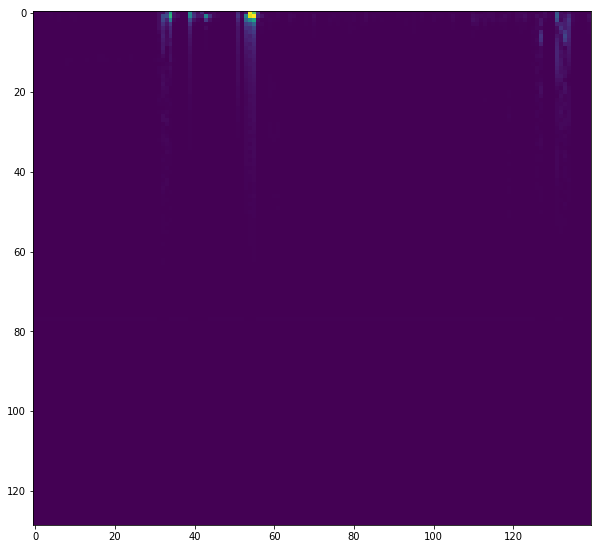

In [58]:
fig = plt.figure(figsize=(10,10))
plt.imshow(Sxxc)

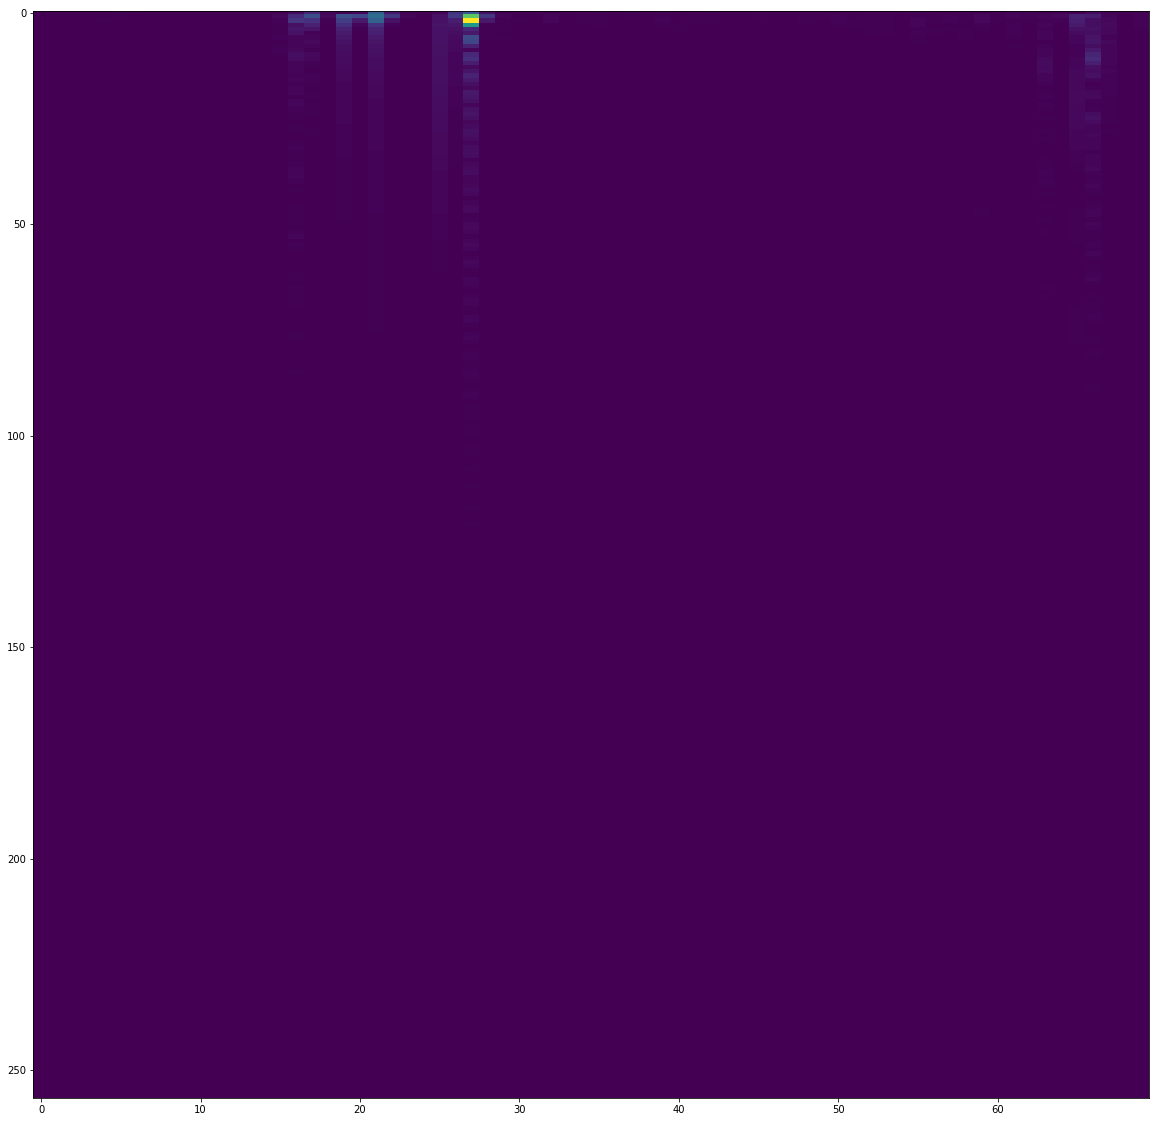

In [32]:
f, t, Sxx_o = signal.spectrogram(record.p_signal[:36000,0], 
                           window=signal.get_window('hann',512, False), 
                           fs=200, 
                           scaling='density', 
                           mode='magnitude',
                           noverlap=0
                          )
fig = plt.figure(figsize=(20,20))
plt.imshow(Sxx_o, aspect='auto')

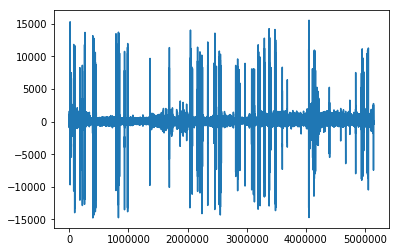

In [42]:
plt.plot(comb_signal)

In [66]:
for i in range(tst_ann.ann_len - 1):
    print(tst_ann.chan[i], tst_ann.sample[i], tst_ann.aux_note[i])

0 72000 W
0 120000 N1
1 124524 (resp_centralapnea
1 127604 resp_centralapnea)
0 132000 W
0 138000 N1
0 156000 N2
0 168000 W
1 172524 (resp_centralapnea
0 174000 N1
1 176284 resp_centralapnea)
1 183186 (resp_centralapnea
0 186000 N2
1 186006 resp_centralapnea)
1 192904 (arousal_rera
1 196364 arousal_rera)
1 199652 (arousal_rera
1 203231 arousal_rera)
0 216000 W
0 228000 N1
0 234000 W
1 245252 (resp_centralapnea
0 246000 N1
1 251392 resp_centralapnea)
0 252000 W
1 281430 (arousal_rera
0 282000 N1
1 286010 arousal_rera)
0 288000 W
1 297954 (resp_centralapnea
1 299954 resp_centralapnea)
0 330000 N1
1 332458 (resp_centralapnea
1 337538 resp_centralapnea)
1 345874 (resp_centralapnea
1 349494 resp_centralapnea)
0 372000 N2
0 498000 N3
0 786000 N2
1 797508 (resp_hypopnea
1 802048 resp_hypopnea)
0 804000 N1
1 807108 (arousal_rera
0 810000 N2
1 810868 arousal_rera)
1 816984 (arousal_rera
1 822004 arousal_rera)
0 828000 W
0 840000 N1
1 846021 (resp_centralapnea
1 849161 resp_centralapnea)
1 85170

In [80]:

s_v = tst_ann.sample[start_idx]
e_v = tst_ann.sample[end_idx]

dist = np.subtract(e_v, s_v)
print(s_v + dist//2)

[ 194634  201441  283720  808988  819494  951600 1386946 1414565 1671694
 1679482 1825074 1884746 1921984 1939248 1959704 1982160 2665870 2678954
 2713574 2808440 2867082 2980808 3003156 3022183 3038572 3074378 4802532]


In [37]:
class SleepDataset(Dataset):
    """Physionet 2018 dataset."""

    def __init__(self, records_file, root_dir, s, f):
        """
        Args:
            records_file (string): Path to the records file.
            root_dir (string): Directory with all the signals.

        """
        self.landmarks_frame = pd.read_csv(records_file)[s:f]
        self.root_dir = root_dir

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        folder_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        file_name = self.landmarks_frame.iloc[idx, 0]
#         print(file_name)
#         print(folder_name)
#         file_name='tr03-0005/'
#         folder_name='../data/training/tr03-0005/'
        signals = wfdb.rdrecord(os.path.join(folder_name, file_name[:-1]))
        arousals = h5py.File(os.path.join(folder_name, file_name[:-1] + '-arousal.mat'), 'r')
        tst_ann = wfdb.rdann(os.path.join(folder_name, file_name[:-1]), 'arousal')
        
        POI = []
        for typ in ['arousal_rera', 'resp_hypopnea', 'resp_centralapnea']:
            start_idx = np.where(np.array(tst_ann.aux_note) == '('+typ)
            end_idx = np.where(np.array(tst_ann.aux_note) == typ+')')

            _starts = tst_ann.sample[start_idx]
            _ends = tst_ann.sample[end_idx]

            _width = np.subtract(_ends, _starts)
            _centers = _starts + _width//2
            POI = np.append(POI, _centers)
        
        W = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'W')]
        N1 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N1')]
        N2 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N2')]
        N3 = tst_ann.sample[np.where(np.array(tst_ann.aux_note) == 'N3')]
        
       
        POI = np.append(POI, W)
        POI = np.append(POI, N1)
        POI = np.append(POI, N2)
        POI = np.append(POI, N3)
        np.random.shuffle(POI)
#         POI = arousal_centers
        sample =  ((signals.p_signal, POI), arousals['data']['arousals'].value.clip(min=0).ravel())
        return sample

a = SleepDataset('../data/training/RECORDS', '../data/training/', 0, 2)
print(len(a))
for i in range(1):
    samp = a[i]


2


In [104]:
len(samp[0][1])

27

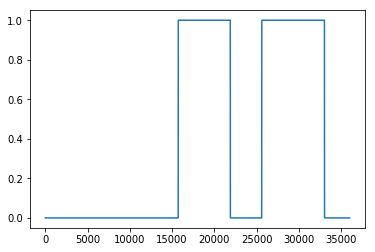

In [94]:
center = samp[0][1][3]
plt.plot(samp[1][center-18000:center+18000])

In [40]:
start = 0 # 2062420 - 36000 
# end = 2065020  + 36000 #
end = start + 36000
# tx1 = x[start:end,8]
# print(record.sig_name[8])
# # tx1 = (tx1 - tx1.mean()) / tx1.std()
# # x = np.linspace(-np.pi, np.pi, 1000)
# f, t, Sxx = signal.spectrogram(tx1, 
#                                window=signal.get_window('hann',126, False), 
#                                fs=200, 
# #                                scaling='density', 
#                                mode='angle',
#                                noverlap=0
#                               )
# fig = plt.figure(figsize=(10, 10))
# # plt.pcolormesh(t, f, Sxx)
# plt.imshow(Sxx, aspect='auto')

# plt.show()

i = 12
tx2 = x[start:end,i]
print(record.sig_name[i])
# tx = (tx - tx.mean()) / tx.std()
# x = np.linspace(-np.pi, np.pi, 1000)
fig = plt.figure(figsize=(10, 10))
plt.plot(tx2)
plt.show
f, t, Sxx = signal.spectrogram(tx2, 
                               window=signal.get_window('hann',512, False), 
                               fs=200, 
                               scaling='density', 
                               mode='magnitude',
                               noverlap=0
                              )
fig = plt.figure(figsize=(10, 10))
# plt.pcolormesh(t, f, Sxx)
plt.imshow(Sxx, aspect='auto')

plt.show()

NameError: name 'x' is not defined

In [39]:
Sxx.shape

NameError: name 'Sxx' is not defined

In [ ]:
print(images.size())
print(outputs)
print(labels.view(-1))

In [64]:
batch_size = 1
n_iters = 3000
num_epochs = 1 # n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_dataset = SleepDataset('../data/training/RECORDS', '../data/training/', 0, 2)
test_dataset = SleepDataset('../data/training/RECORDS', '../data/training/', 2, 4)

train_loaders = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''

# class CNN_M(nn.Module):

#     def __init__(self, num_out):
#         super(CNN_M, self).__init__()
        
        
#     def forward(self, x):
#         return None

'''
STEP 4: INSTANTIATE MODEL CLASS
'''

b = next(enumerate(train_loaders))
print(b)
model = CNN_M(3600)

model(b[0])

#######################
#  USE GPU FOR MODEL  #
#######################

# if torch.cuda.is_available():
#     model.cuda()
    
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.NLLLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.1

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  



idx 0
(0, [
(   0   ,.,.) = 
    -9.0000     5.0000    -5.0000  ...     39.0000    96.5347    -0.0530
   -36.0000     2.0000   -33.0000  ...     93.0000    96.5347    -0.1030
   -23.0000     2.0000   -23.0000  ...     62.0000    96.5347     0.0060
               ...                  ⋱                 ...               
     0.0000     0.0000     0.0000  ...     -6.0000     0.4959     0.5430
     0.0000     0.0000     0.0000  ...      3.0000     0.4959    -0.7280
     0.0000     0.0000     0.0000  ...      4.0000     0.4959    -0.0720
[torch.DoubleTensor of size 1x5147000x13]
, 
    0     0     0  ...      0     0     0
[torch.DoubleTensor of size 1x5147000]
])


'\nSTEP 6: INSTANTIATE OPTIMIZER CLASS\n'

In [147]:
s = 199652
subs = b[1][0][:,s-18000:s+18000,]
labs = b[1][1][0, s-18000:s+18000]

v = 281430

v_subs = b[1][0][:,v-18000:v+18000,]
v_labs = b[1][1][0, v-18000:v+18000]


print(subs.size())
print(labs.size())


print(v_subs.size())
print(v_labs.size())

torch.Size([1, 36000, 13])
torch.Size([36000])
torch.Size([1, 36000, 13])
torch.Size([36000])


In [159]:
# print(subs[0,:,0])
f, t, Sxx = signal.spectrogram(subs[0,:,0].numpy(), 
                           window=signal.get_window('hann',256, False), 
                           fs=200, 
                           scaling='density', 
                           mode='magnitude',
                           noverlap=0
                          )
print(Sxx.shape)

(129, 140)


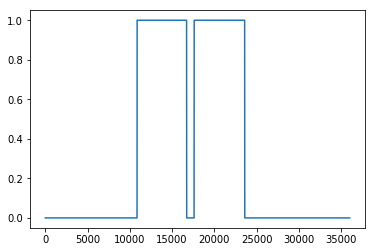

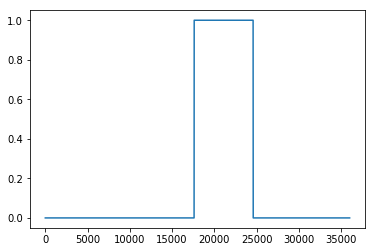

In [5]:
plt.plot(labs.numpy())
plt.show()
plt.plot(v_labs.numpy())
plt.show()

epoch 0 loss 36.464908484875096 time 14.503508806228638


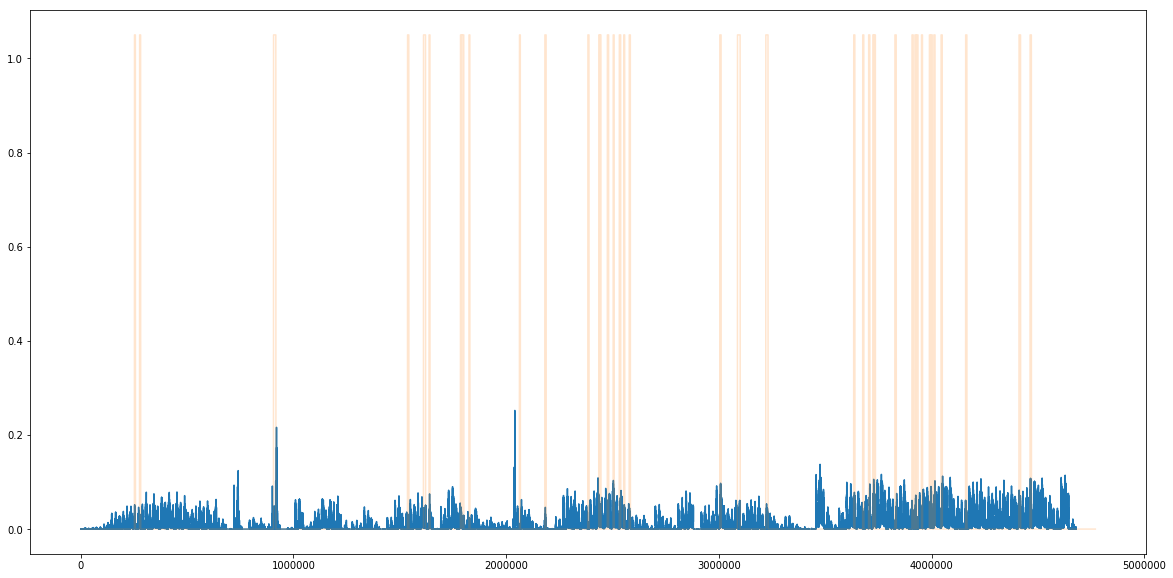

epoch 1 loss 27.379553701175865 time 14.649306535720825


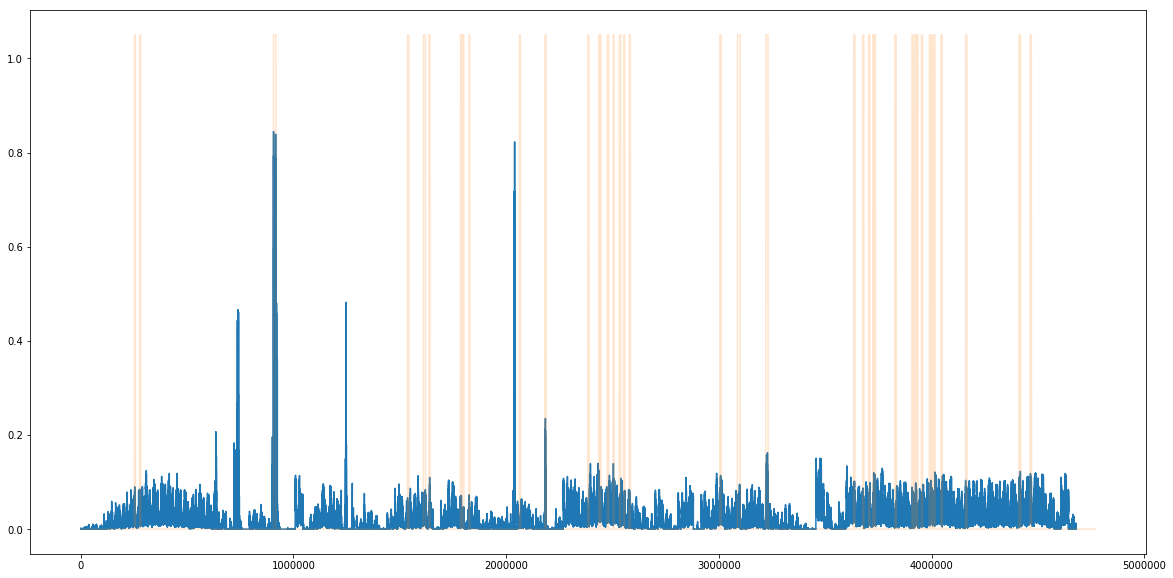

epoch 2 loss 23.669884841393213 time 14.5887930393219


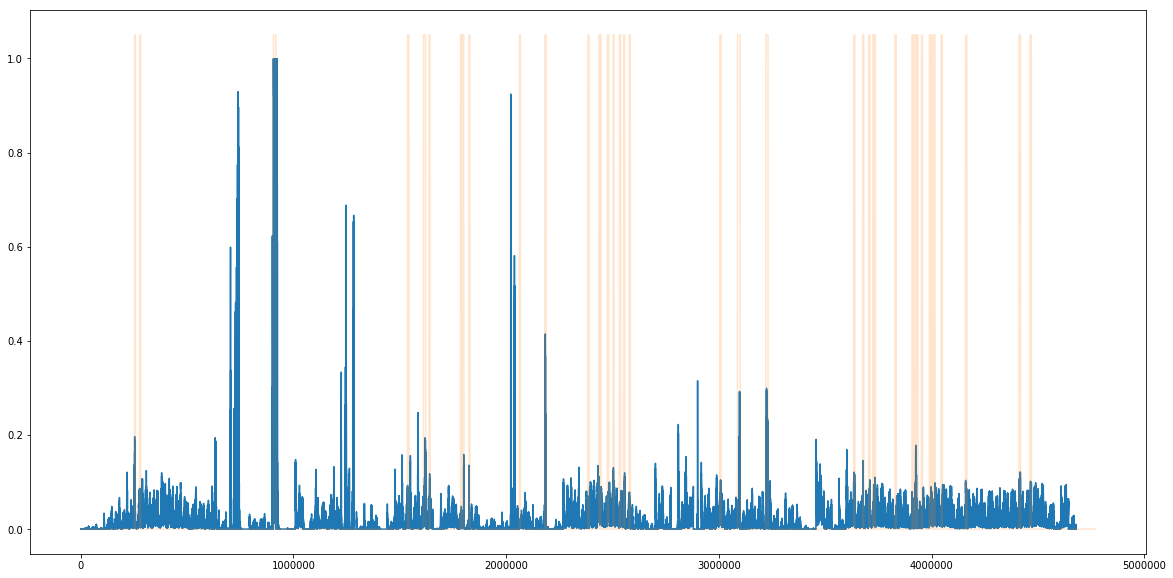

epoch 3 loss 20.750902223526047 time 14.457926750183105


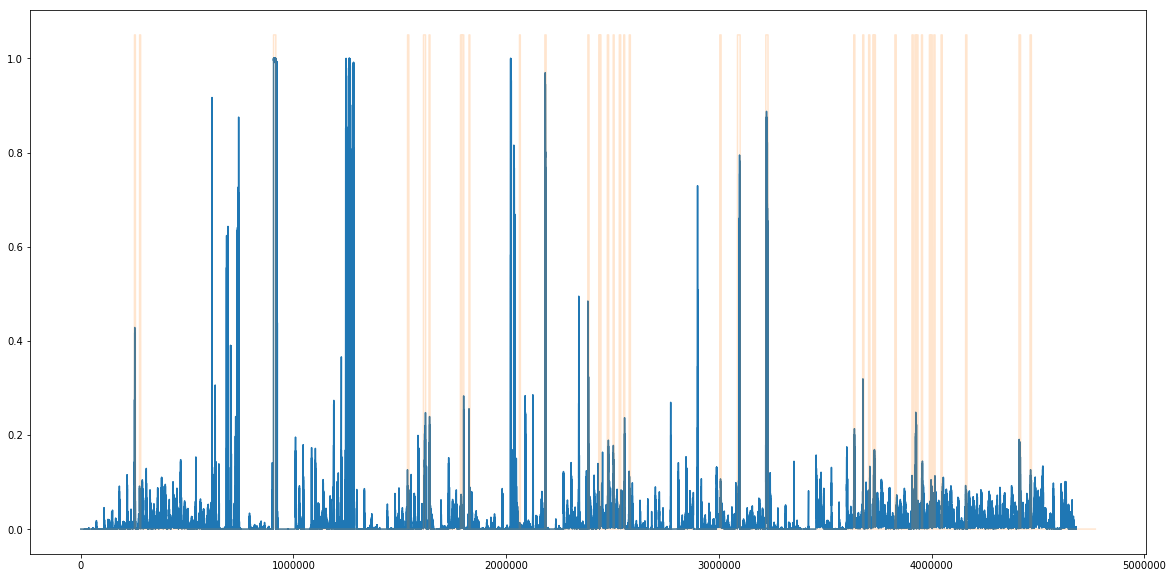

epoch 4 loss 19.726595725207297 time 14.504287004470825


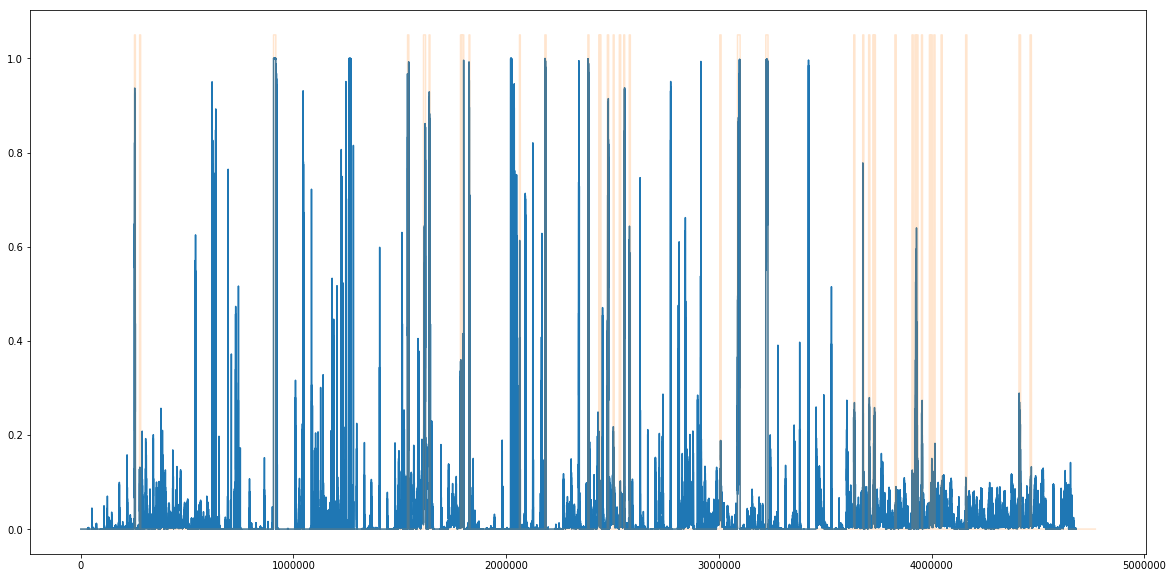

epoch 5 loss 15.230147828706425 time 14.496840238571167


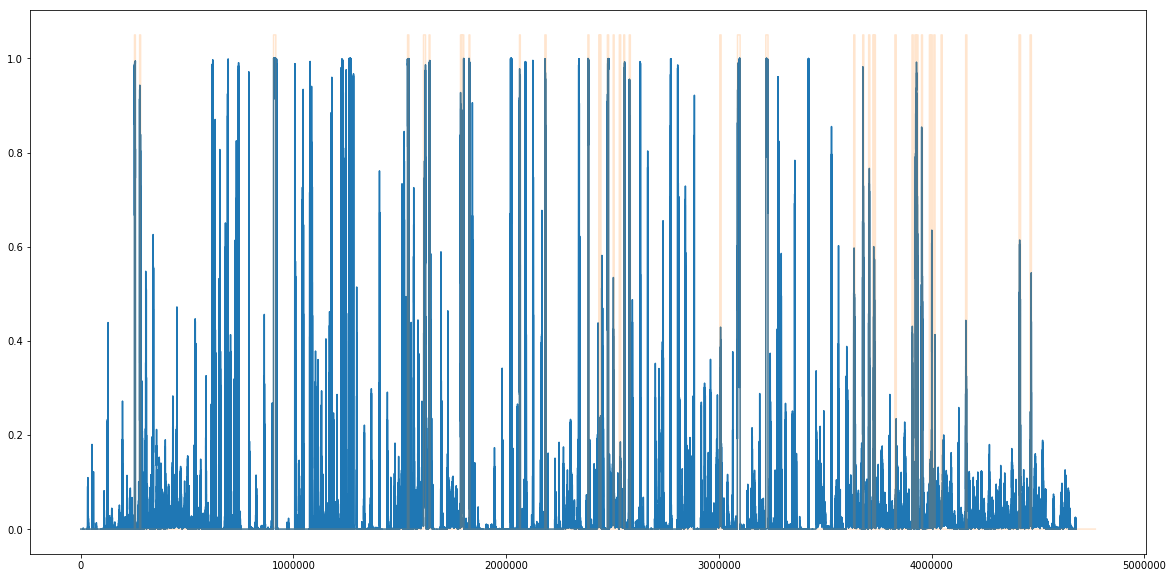

epoch 6 loss 11.227504737112476 time 14.536746740341187


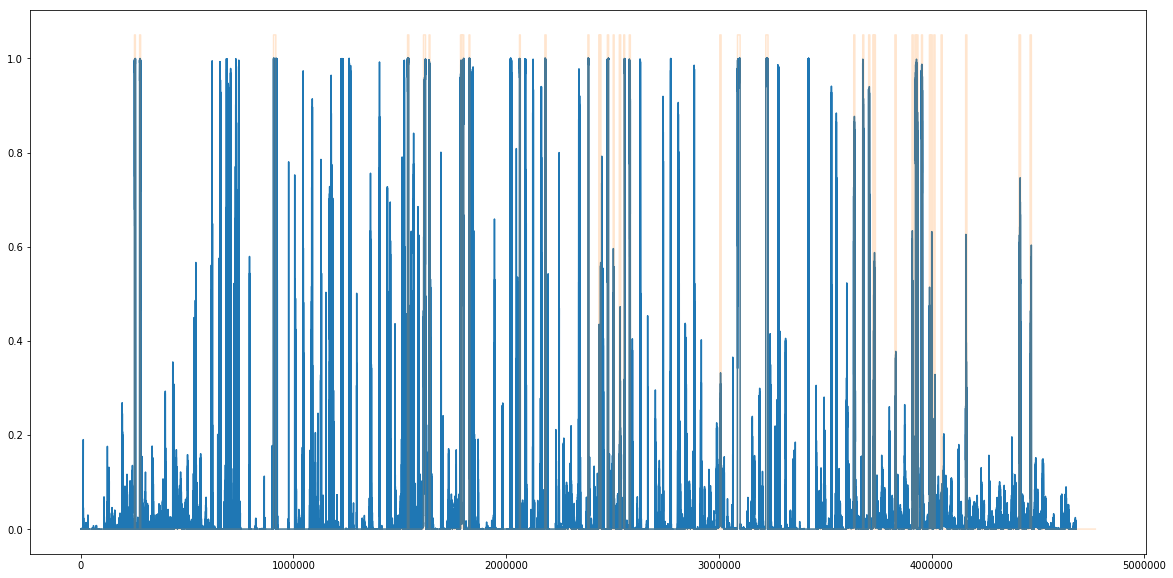

epoch 7 loss 7.980816085010652 time 14.552910566329956


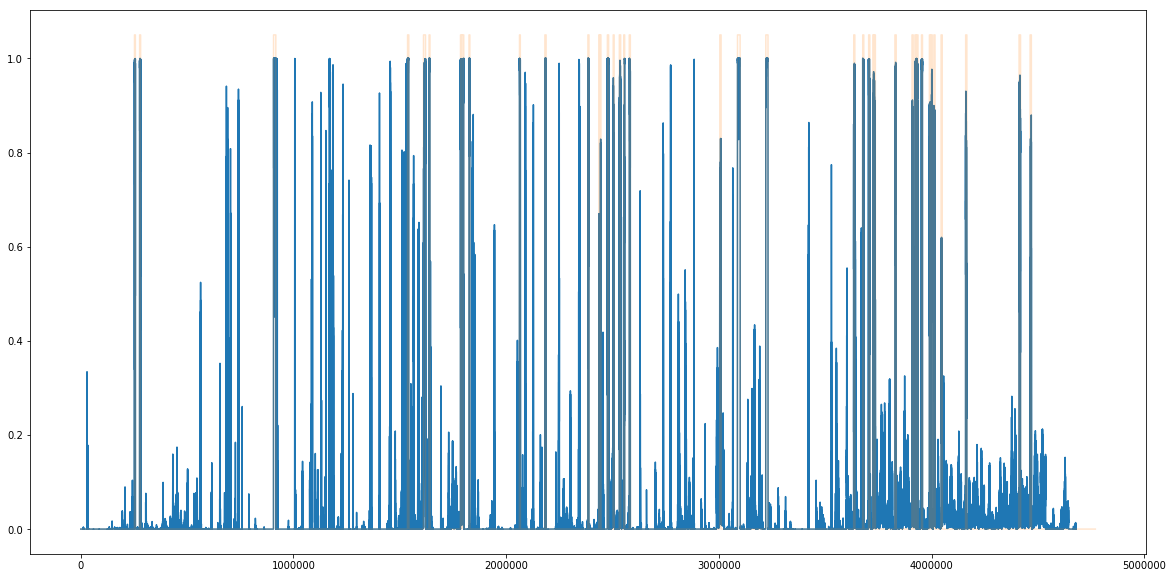

epoch 8 loss 4.567172467744682 time 14.509915828704834


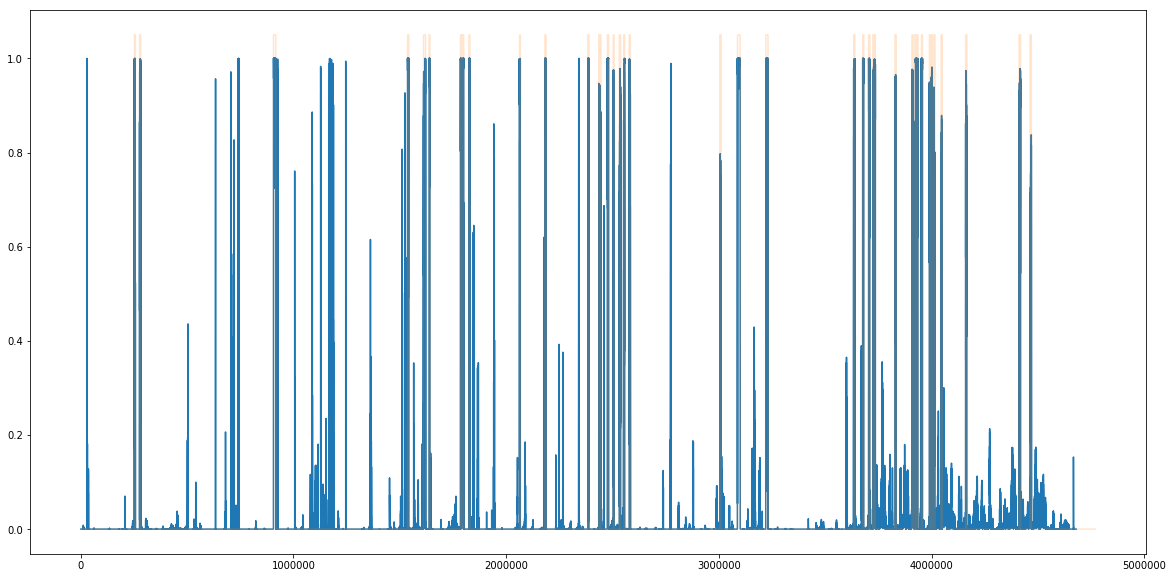

epoch 9 loss 6.478642805046074 time 14.656014680862427


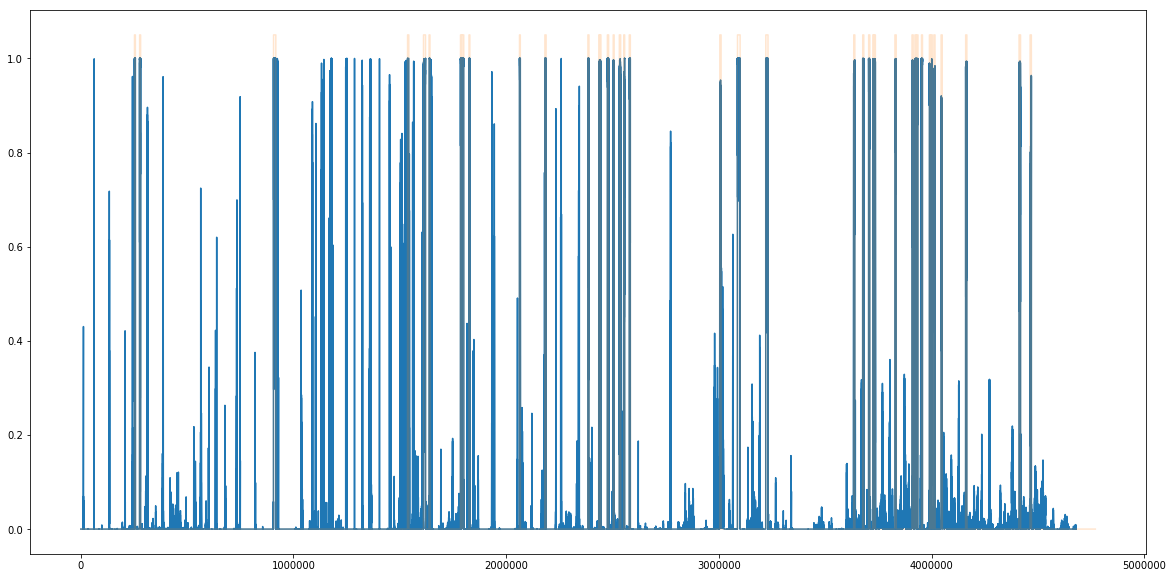

epoch 10 loss 1.9755785971769857 time 14.606394529342651


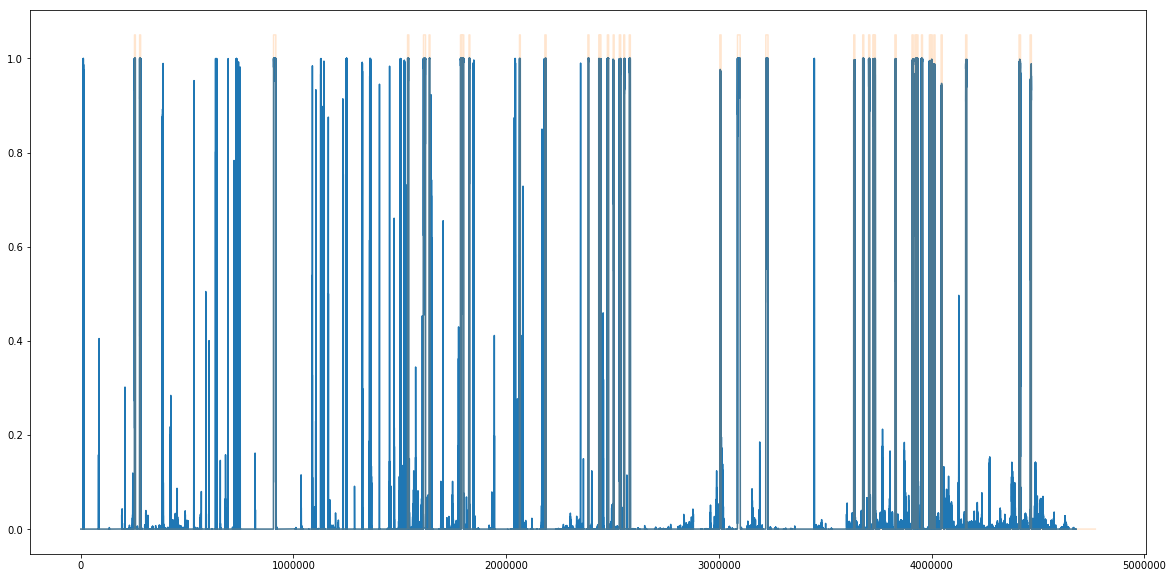

epoch 11 loss 1.3351251926262622 time 14.484795331954956


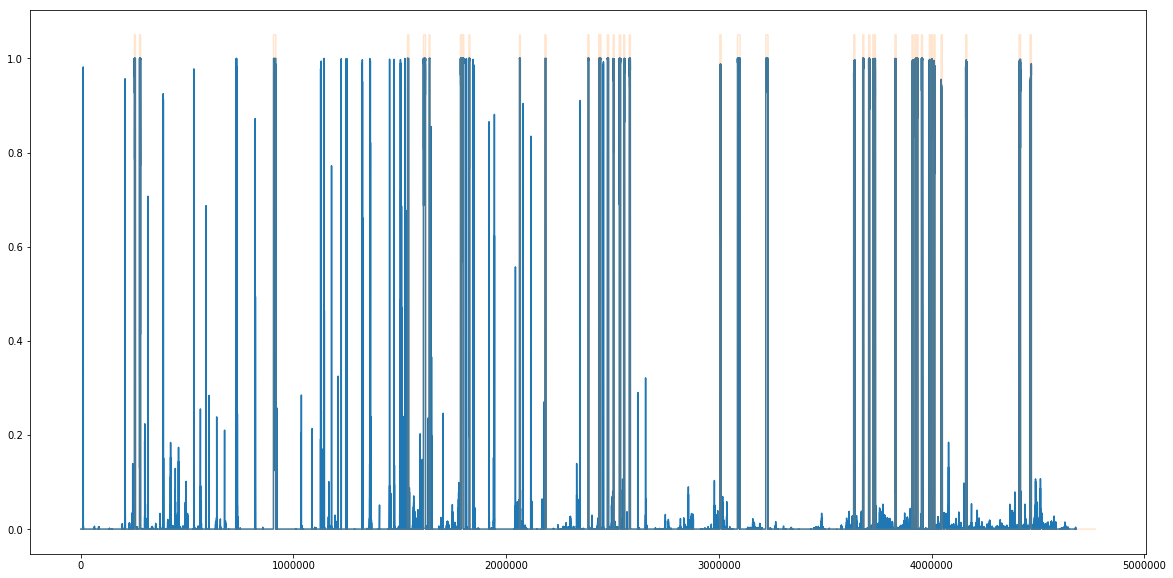

epoch 12 loss 0.31602474517479995 time 14.655454635620117


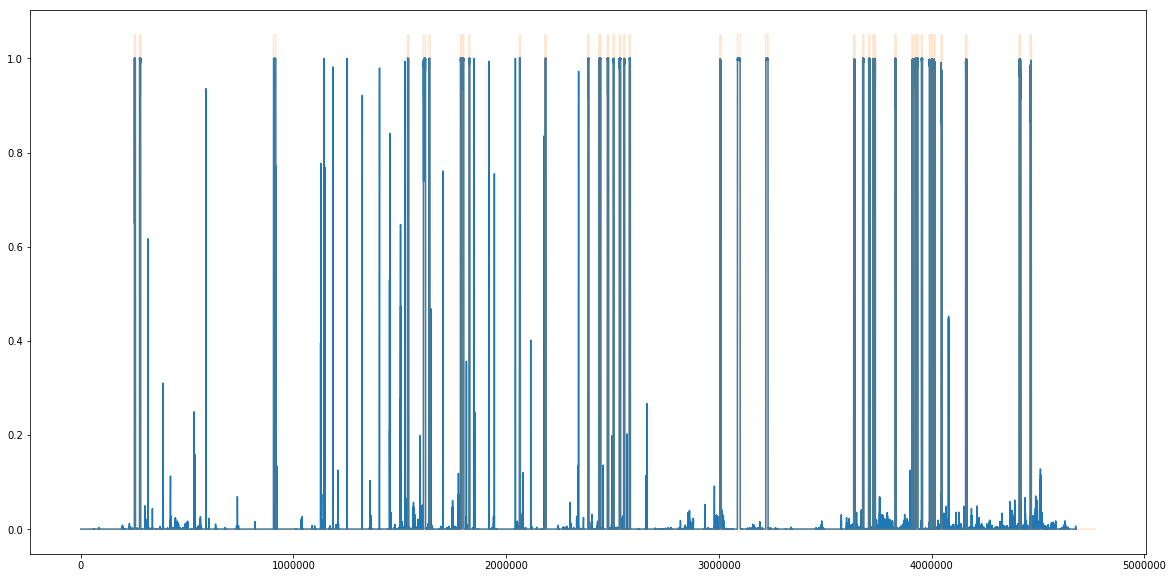

epoch 13 loss 0.12920450617215962 time 14.478113174438477


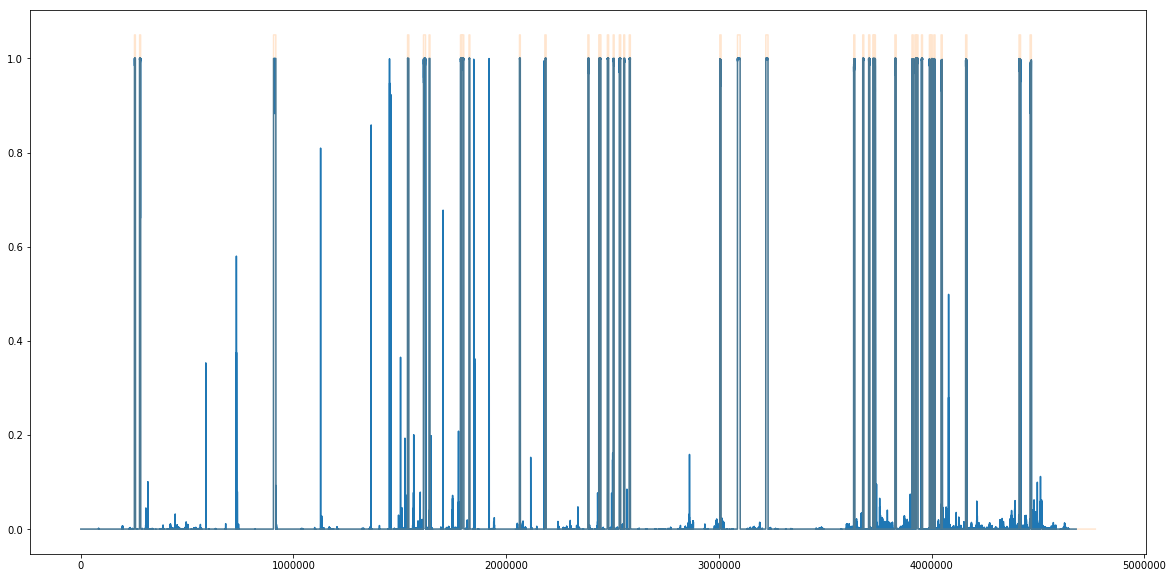

epoch 14 loss 0.0677206360057607 time 14.548558235168457


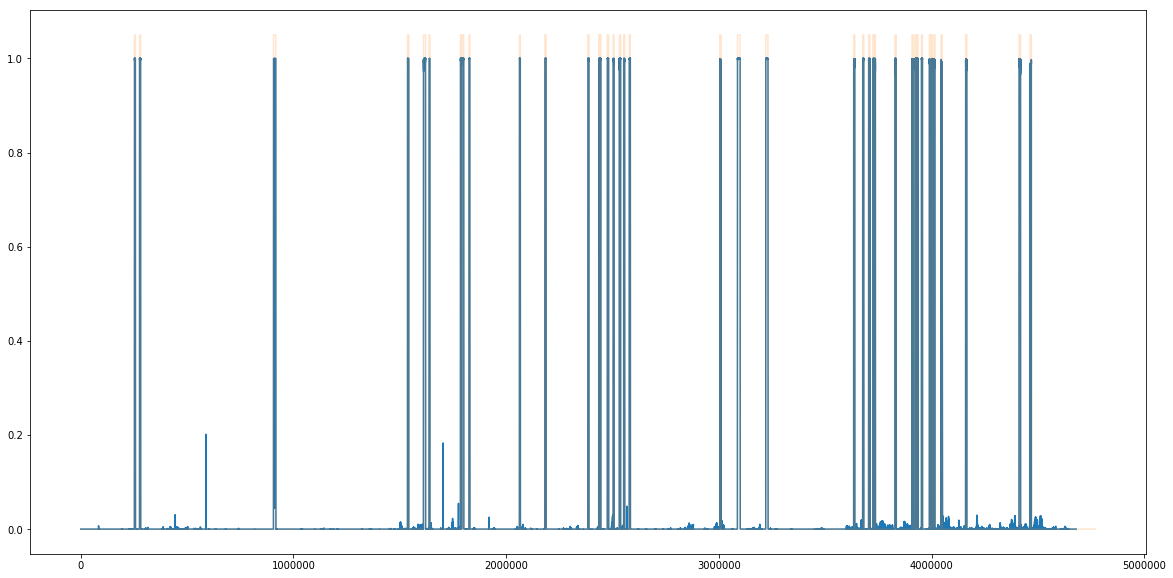

epoch 15 loss 0.04860119442196083 time 14.647394895553589


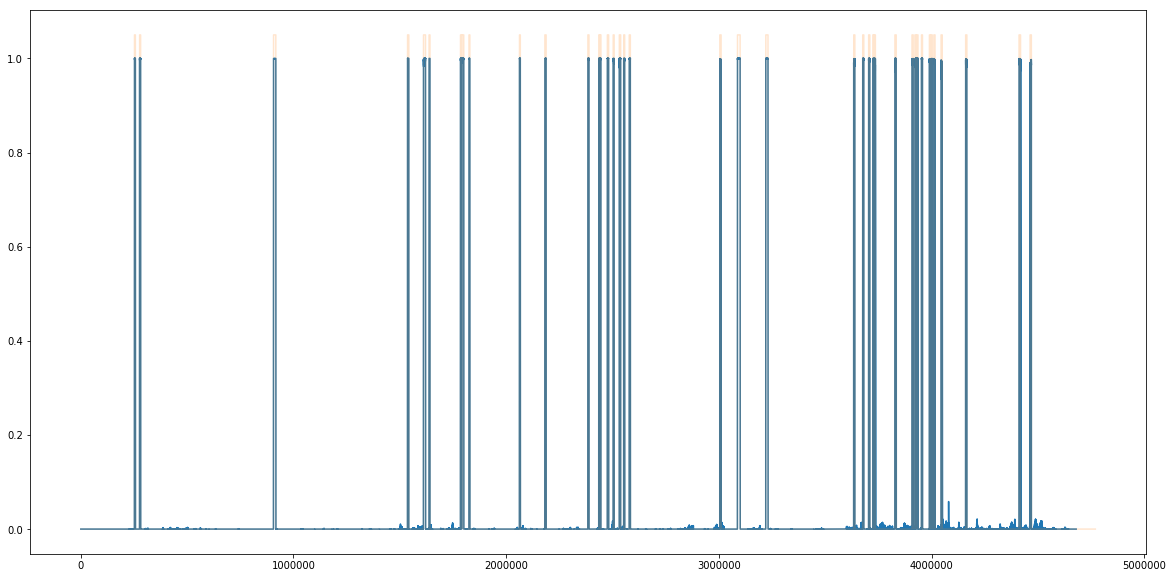

epoch 16 loss 0.037036723170369504 time 14.53098201751709


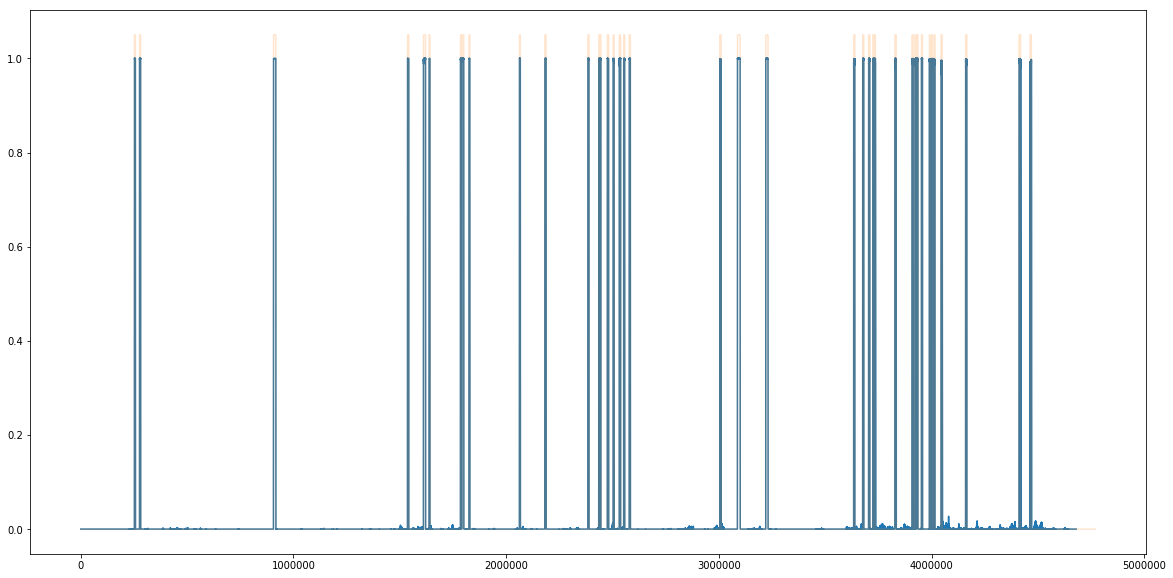

epoch 17 loss 0.029591625156224592 time 14.5738046169281


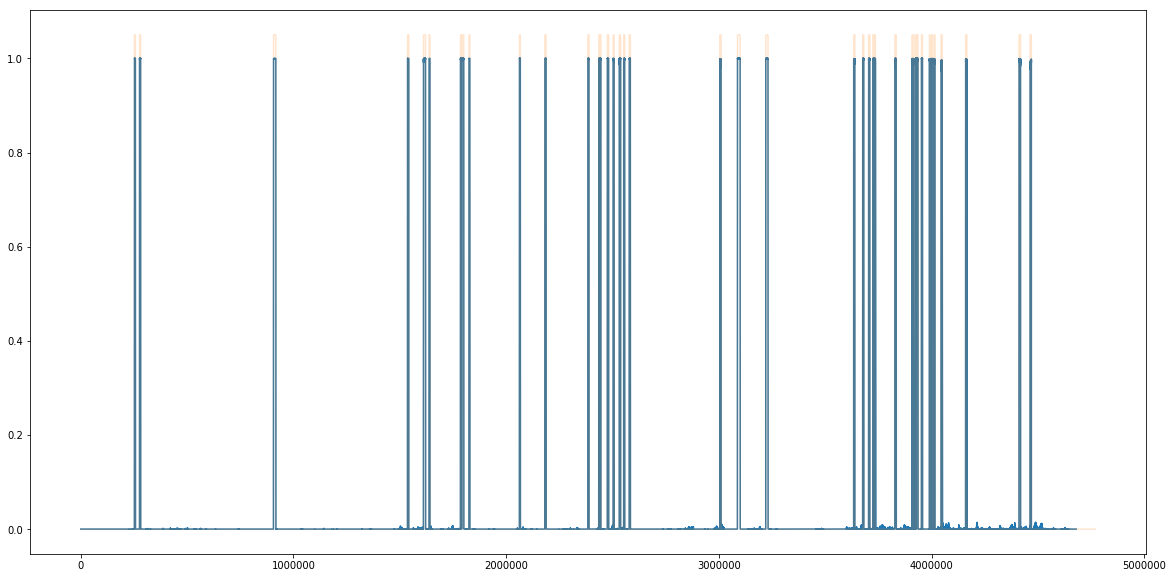

epoch 18 loss 0.02422175967807352 time 14.589961528778076


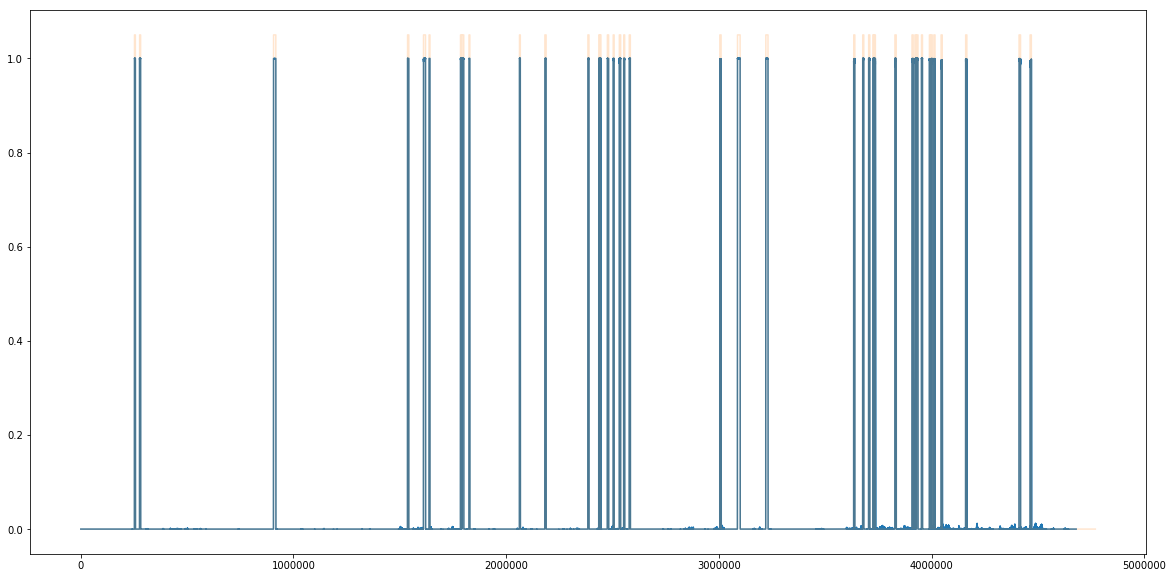

epoch 19 loss 0.020154447192142357 time 14.692248106002808


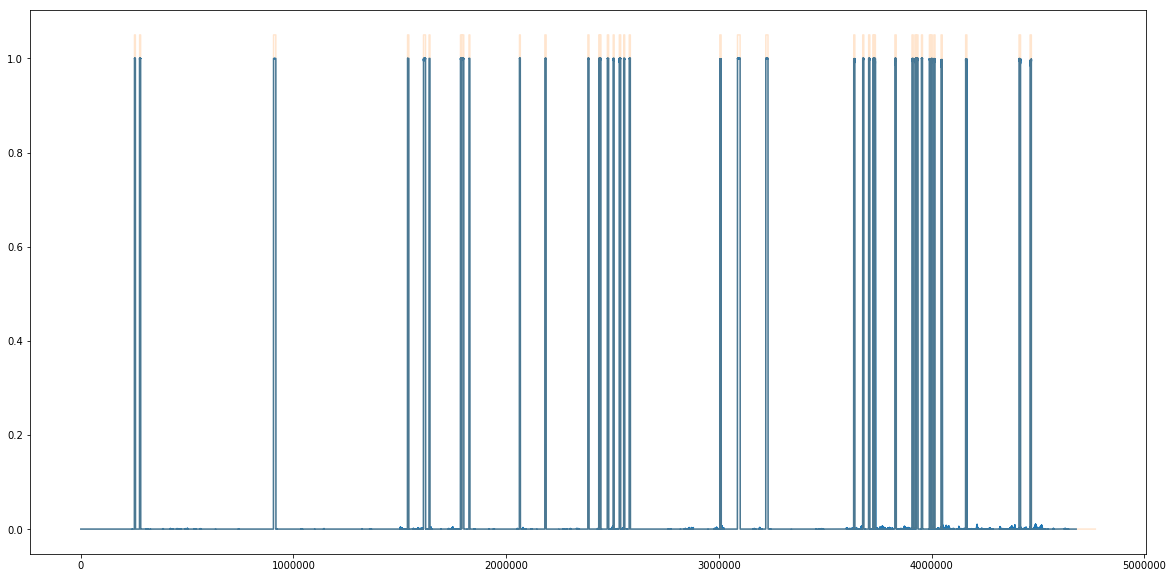

epoch 20 loss 0.017008855504553486 time 14.376227378845215


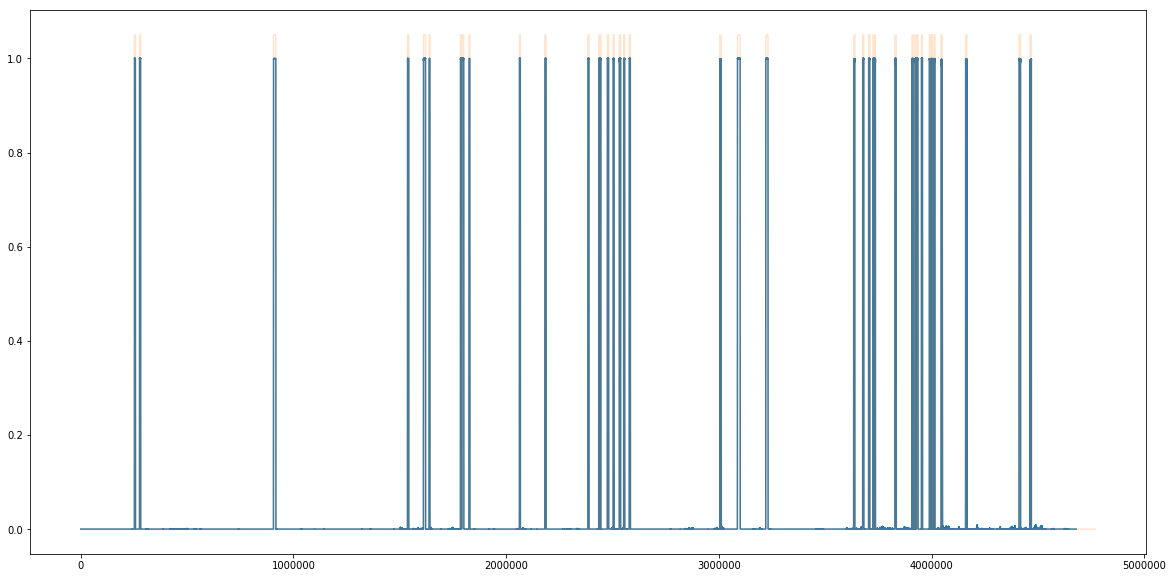

epoch 21 loss 0.014544522340695646 time 14.541970491409302


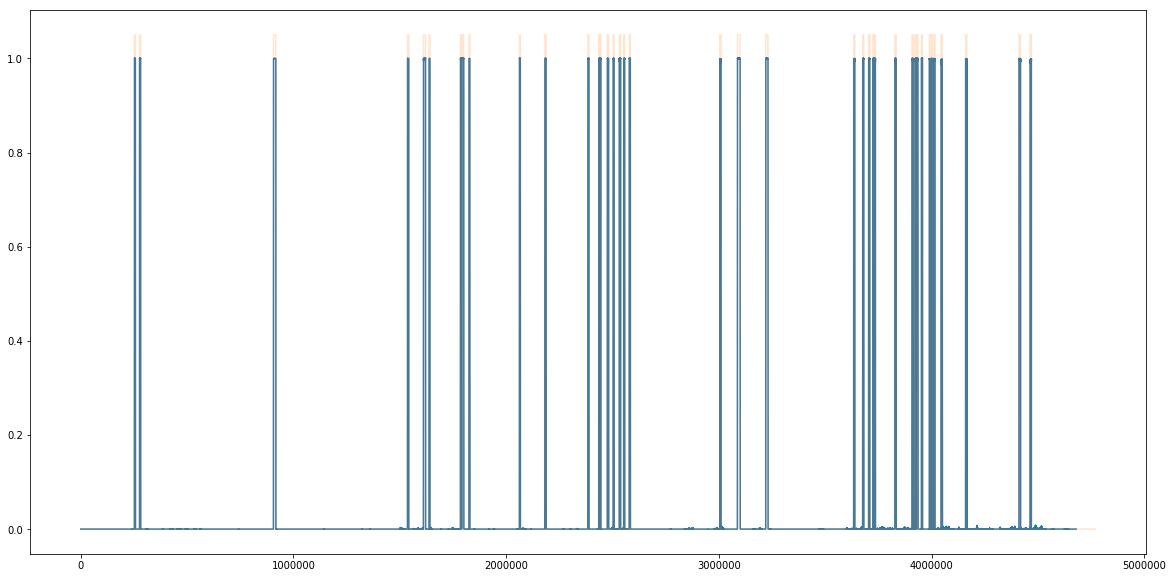

epoch 22 loss 0.012551419640863645 time 14.648503303527832


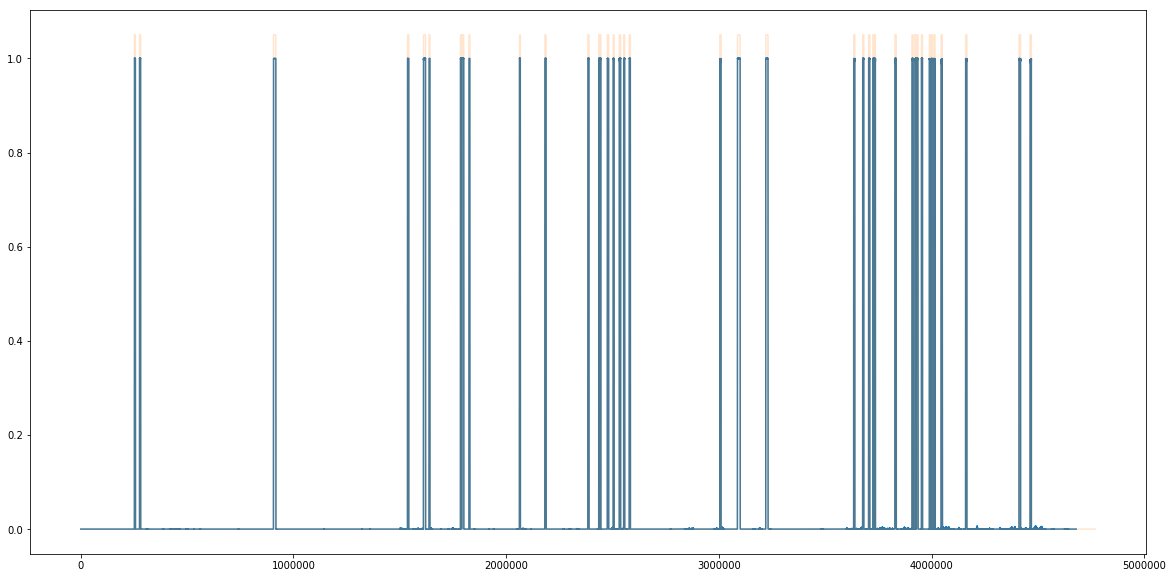

epoch 23 loss 0.010922464133992166 time 14.425728559494019


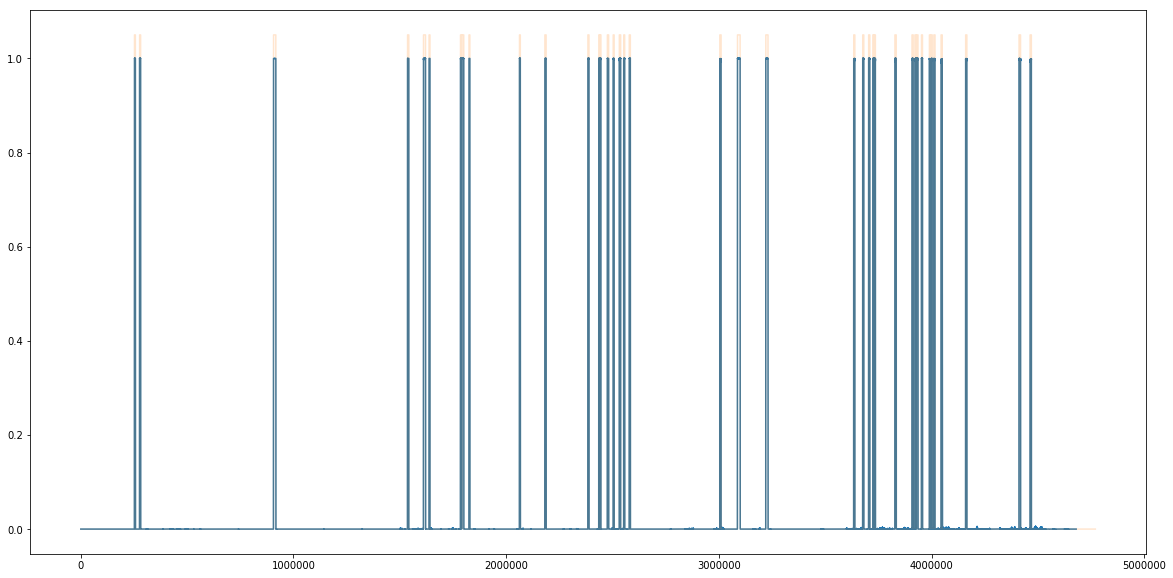

epoch 24 loss 0.009569023864929655 time 14.581804990768433


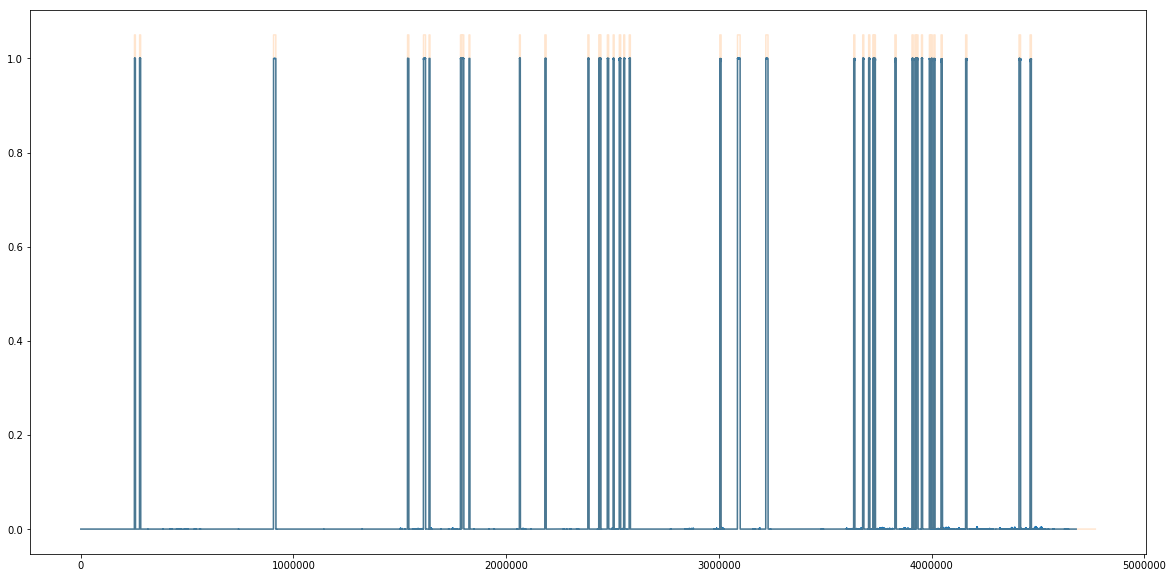

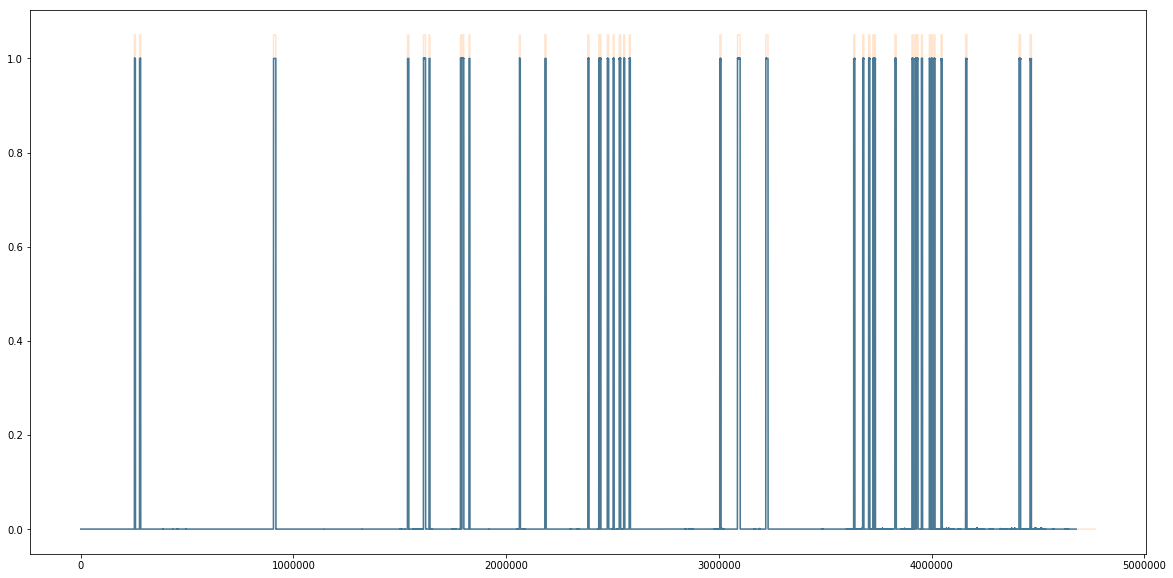

epoch 31 loss 0.004276864884253452 time 14.476415157318115


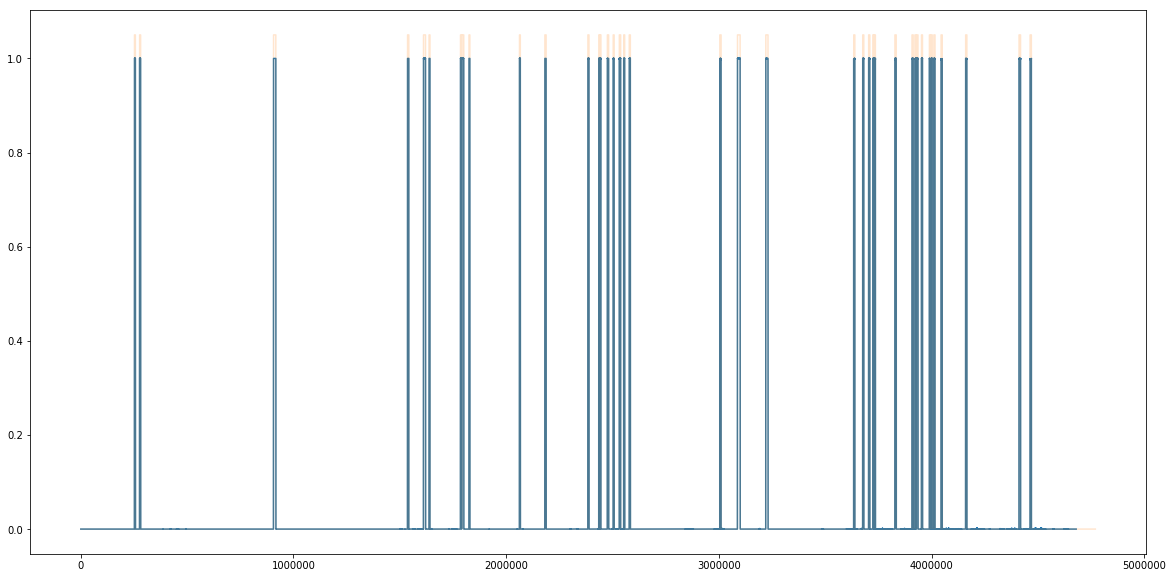

epoch 32 loss 0.00385812709433049 time 14.470670461654663


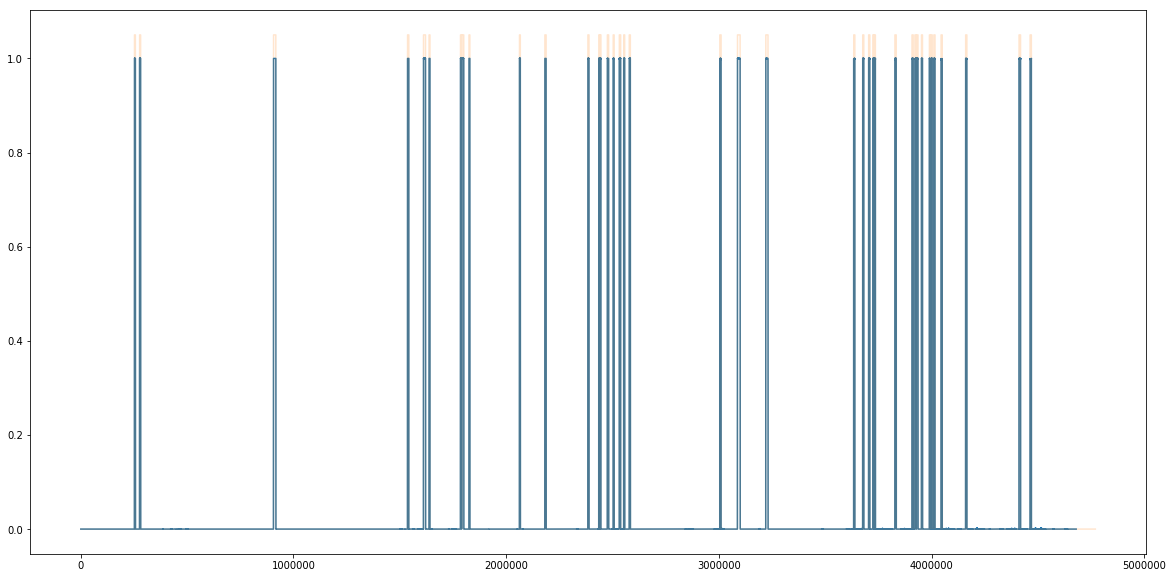

epoch 33 loss 0.003486925378479986 time 14.580178260803223


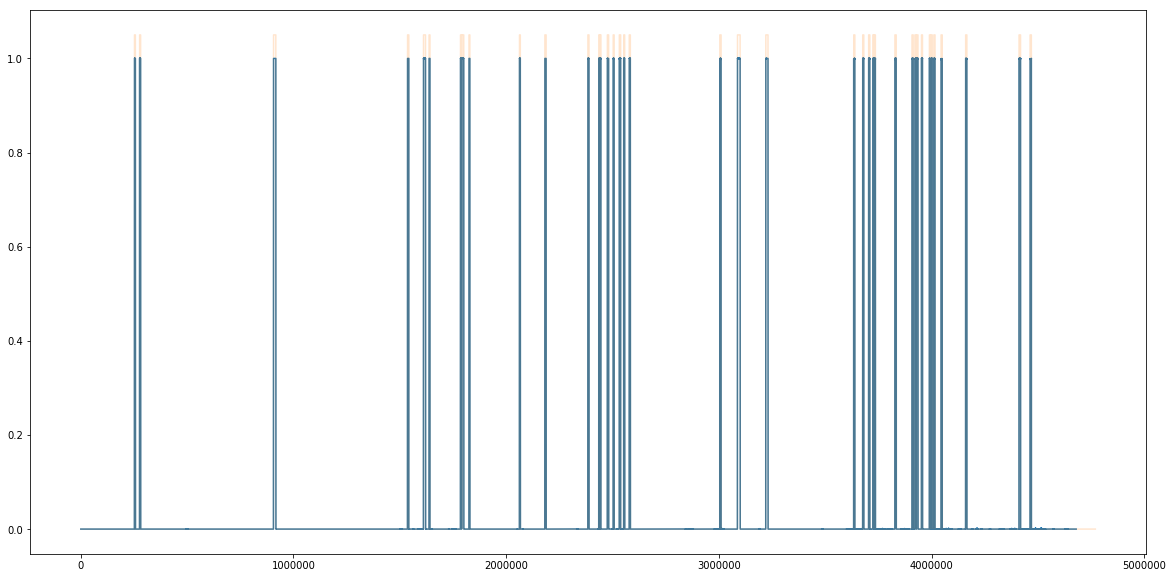

epoch 34 loss 0.0031576831614183276 time 14.545945167541504


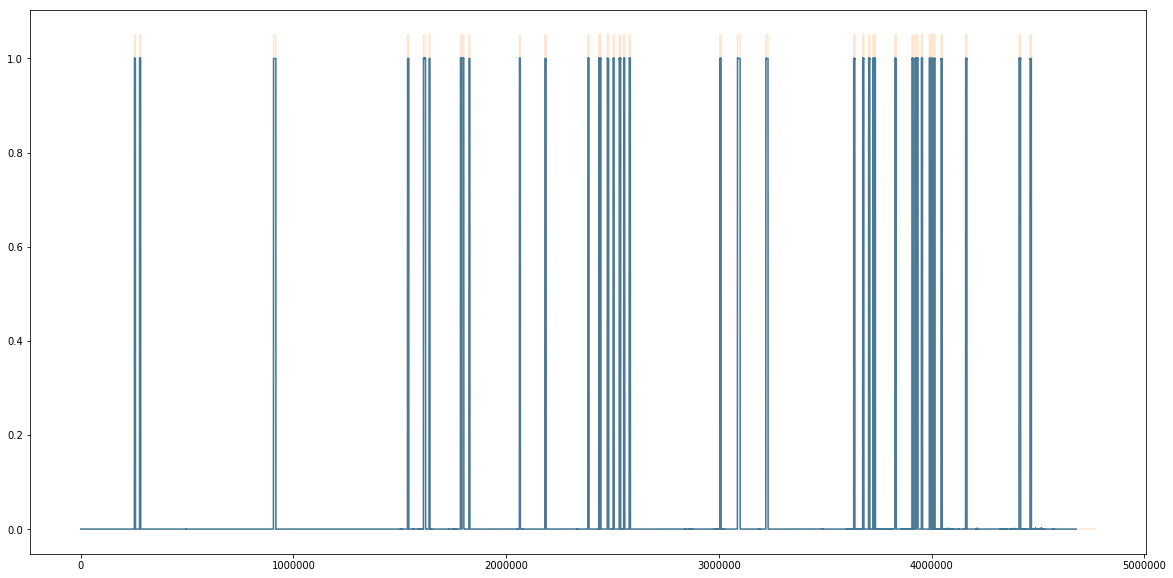

epoch 35 loss 0.0028634753483223925 time 14.594470262527466


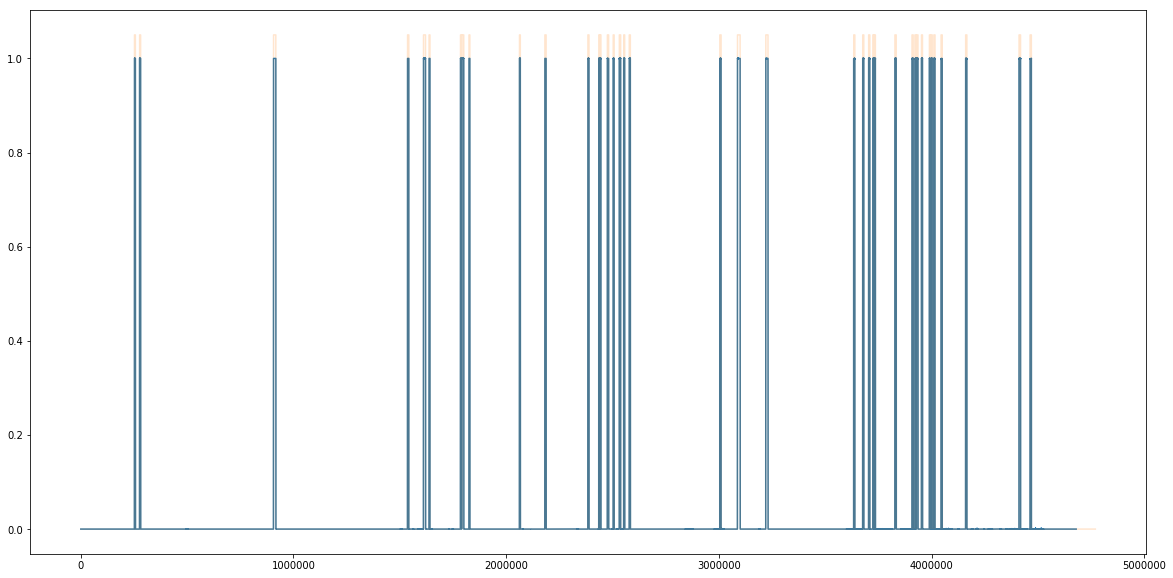

epoch 36 loss 0.002600381606383685 time 14.591475009918213


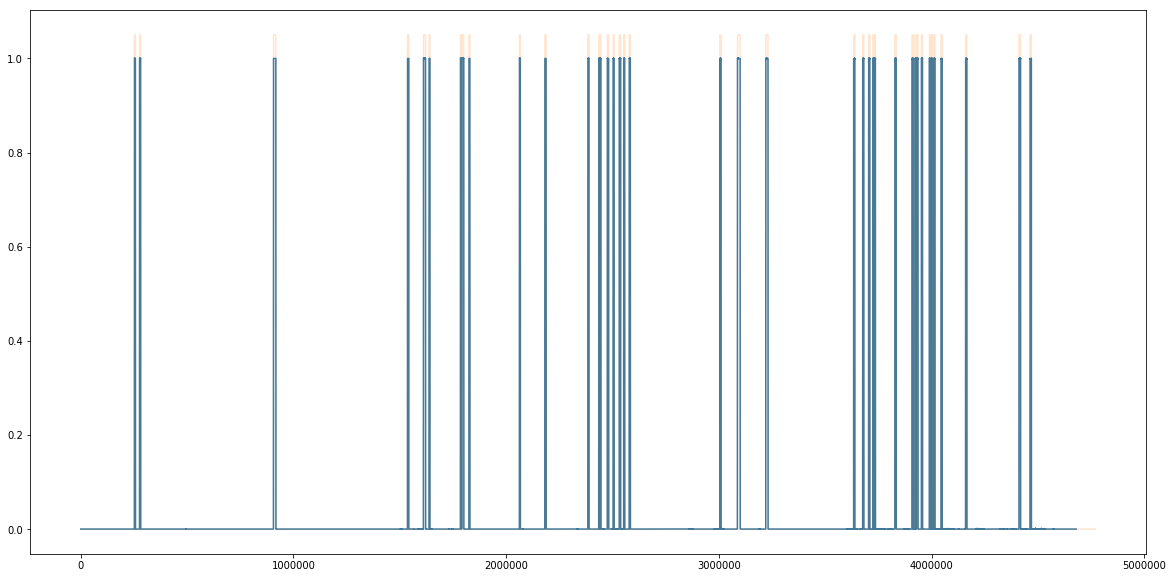

epoch 37 loss 0.002365988218463271 time 14.433856964111328


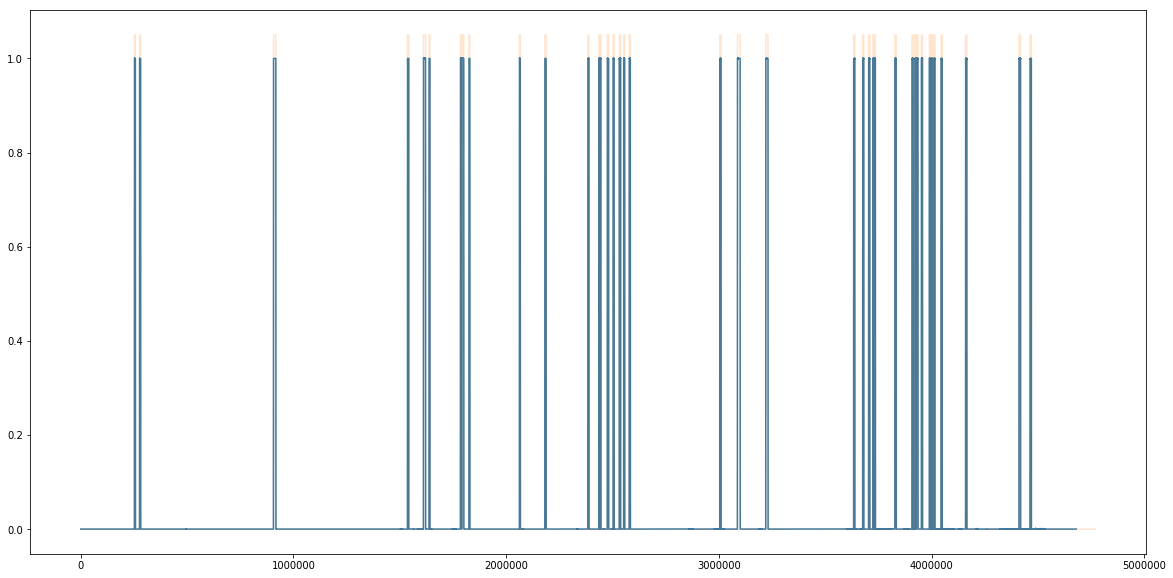

epoch 38 loss 0.0021538361083567516 time 14.786320686340332


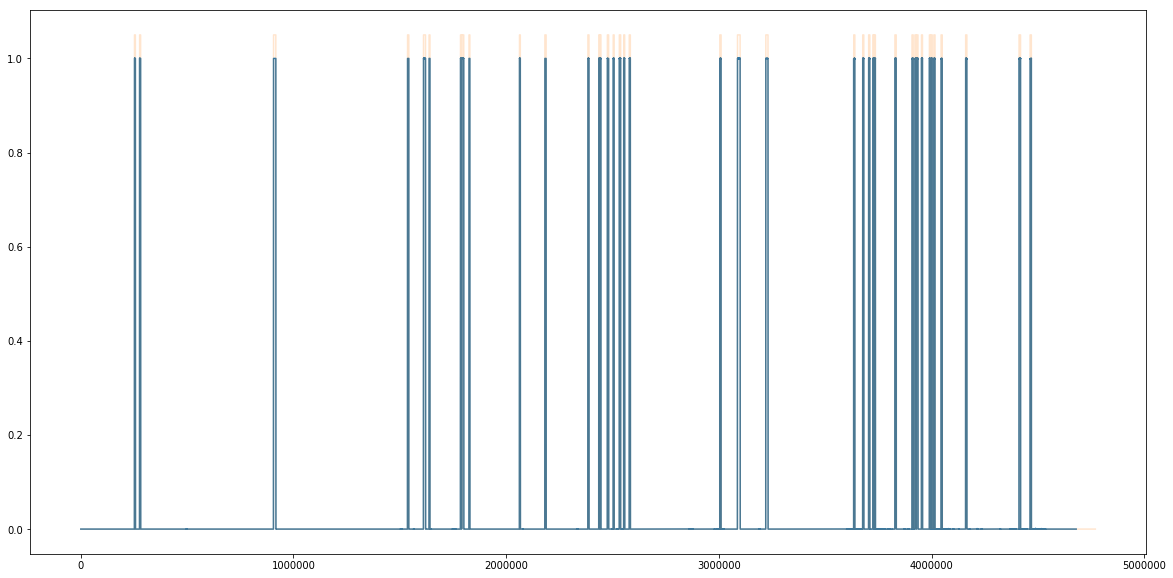

epoch 39 loss 0.001964923731341774 time 14.576211214065552


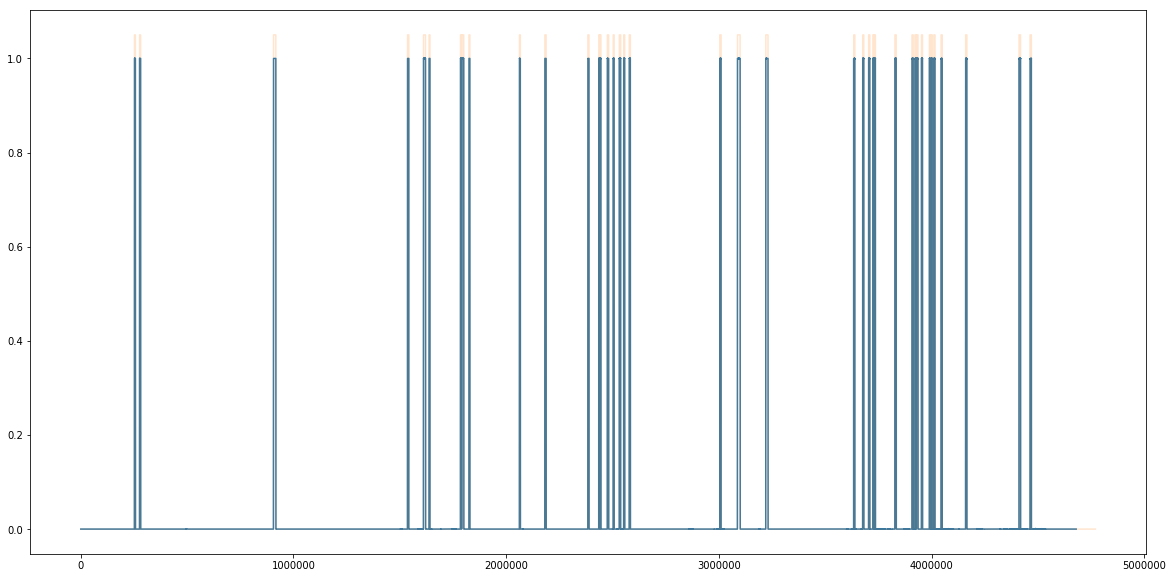

epoch 40 loss 0.0017937136165865168 time 14.673567056655884


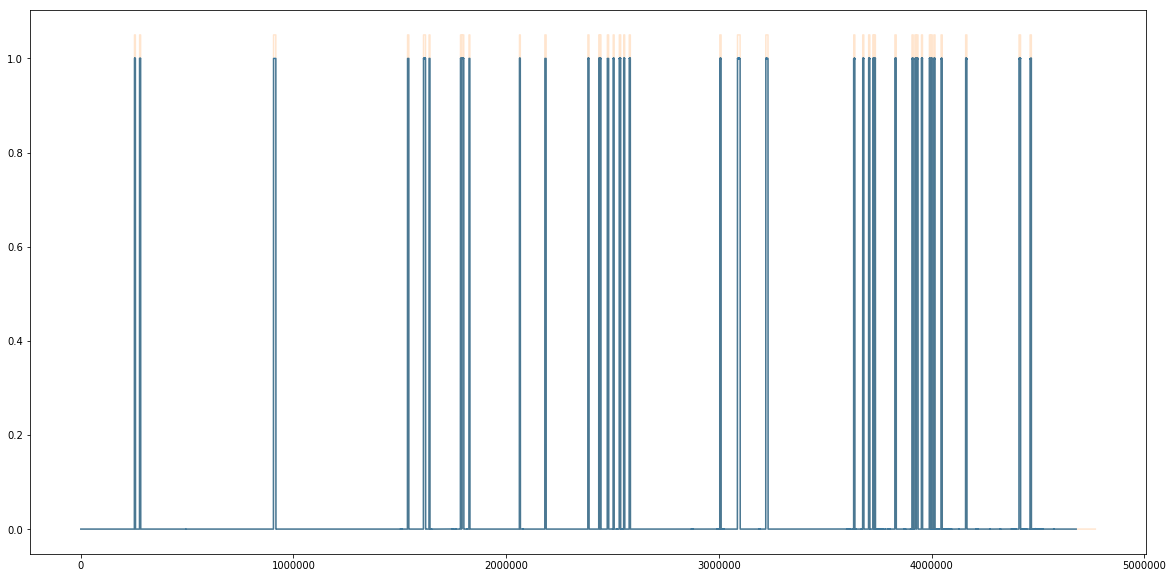

epoch 41 loss 0.0016393141318597655 time 14.443359136581421


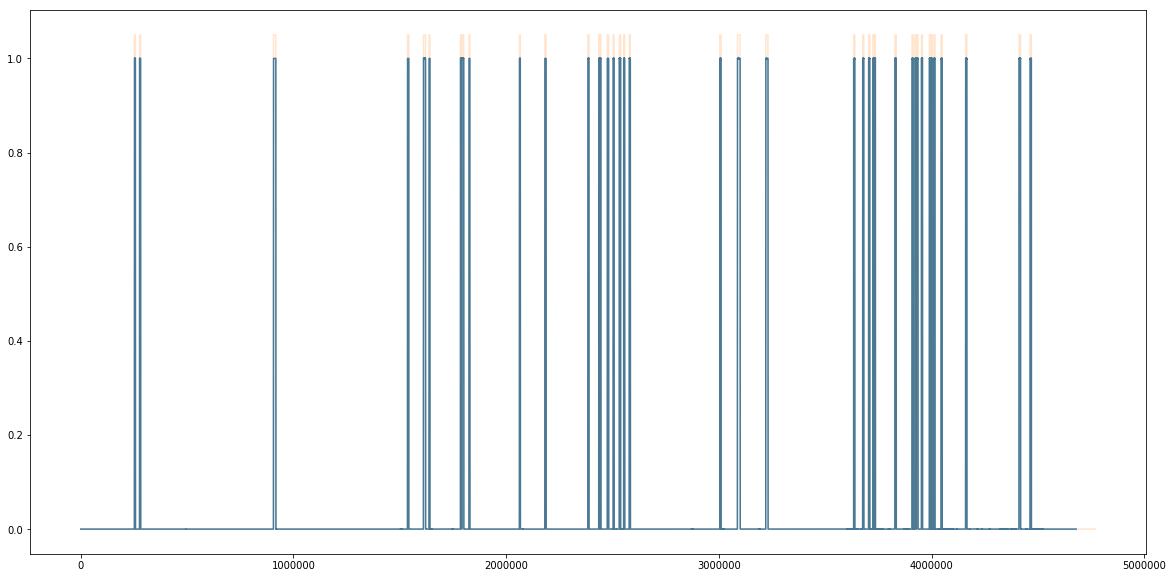

epoch 42 loss 0.0014996700707995518 time 14.5410475730896


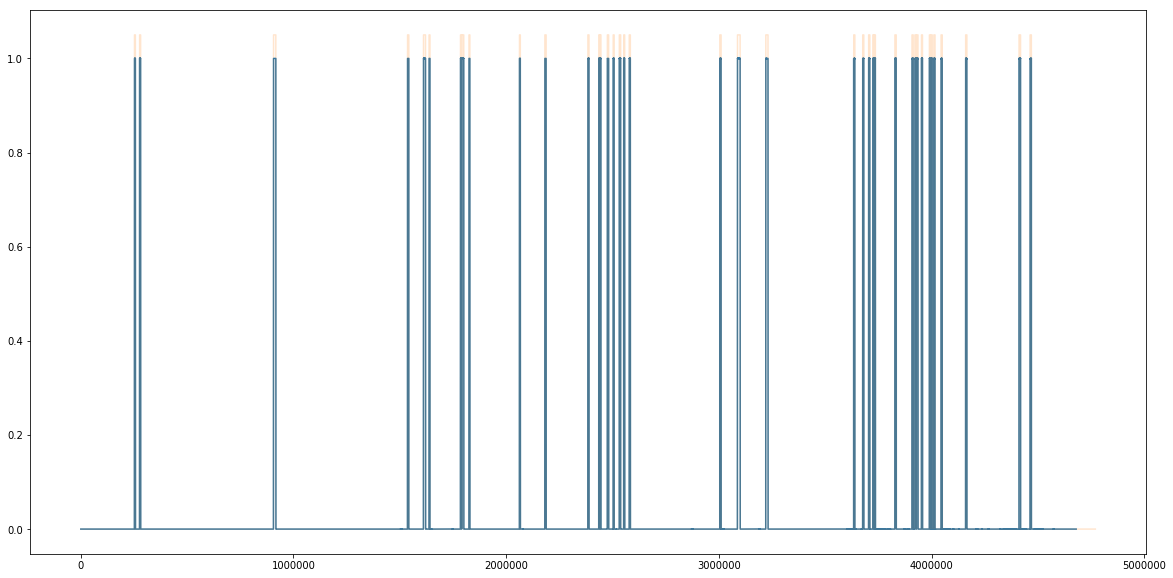

epoch 43 loss 0.0013730238818968963 time 14.603843212127686


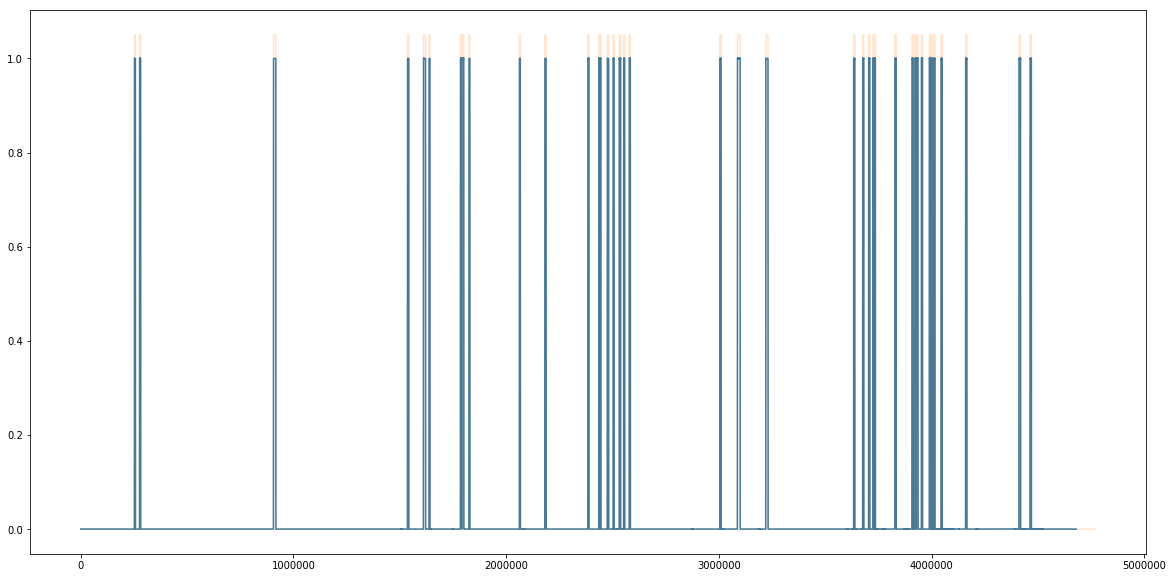

epoch 44 loss 0.0012586253039716497 time 14.554337739944458


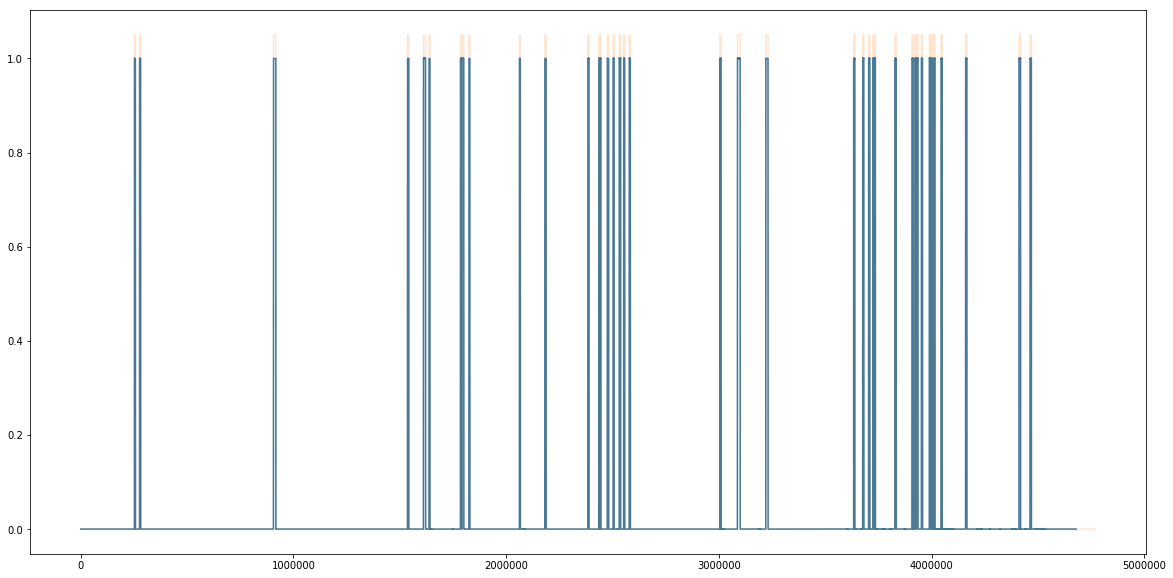

epoch 45 loss 0.0011549944717725992 time 14.548820495605469


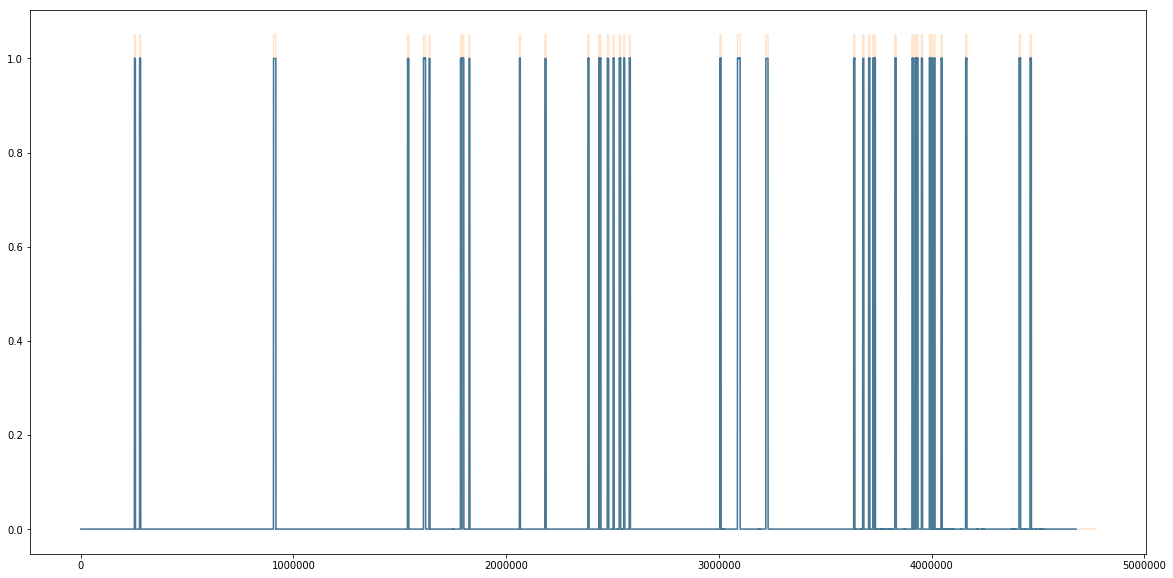

epoch 46 loss 0.0010606513040539822 time 14.5530686378479


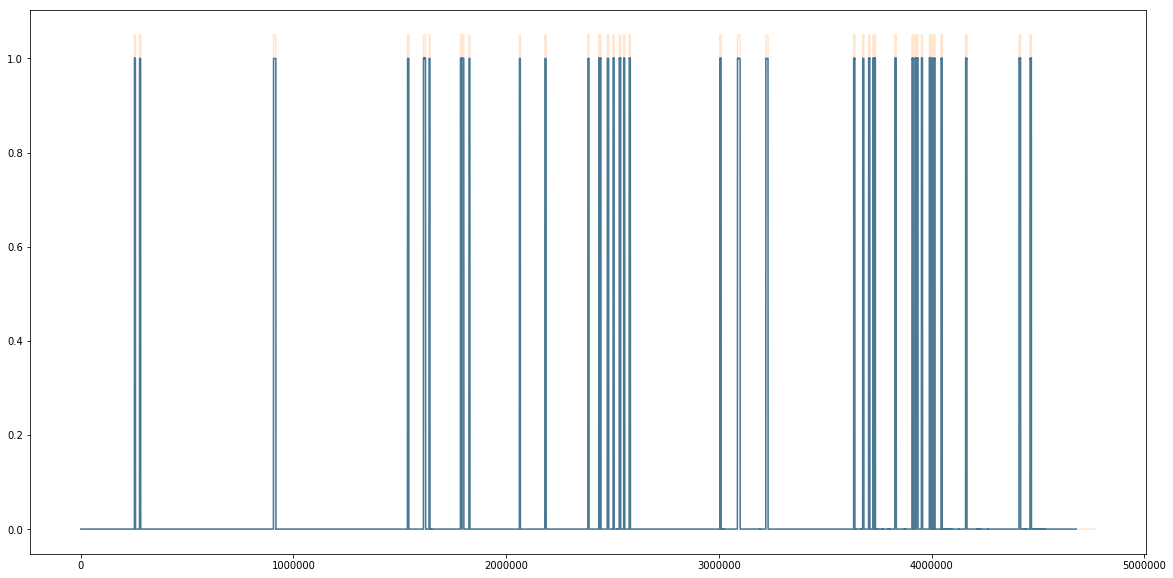

epoch 47 loss 0.0009753413142439648 time 14.575295448303223


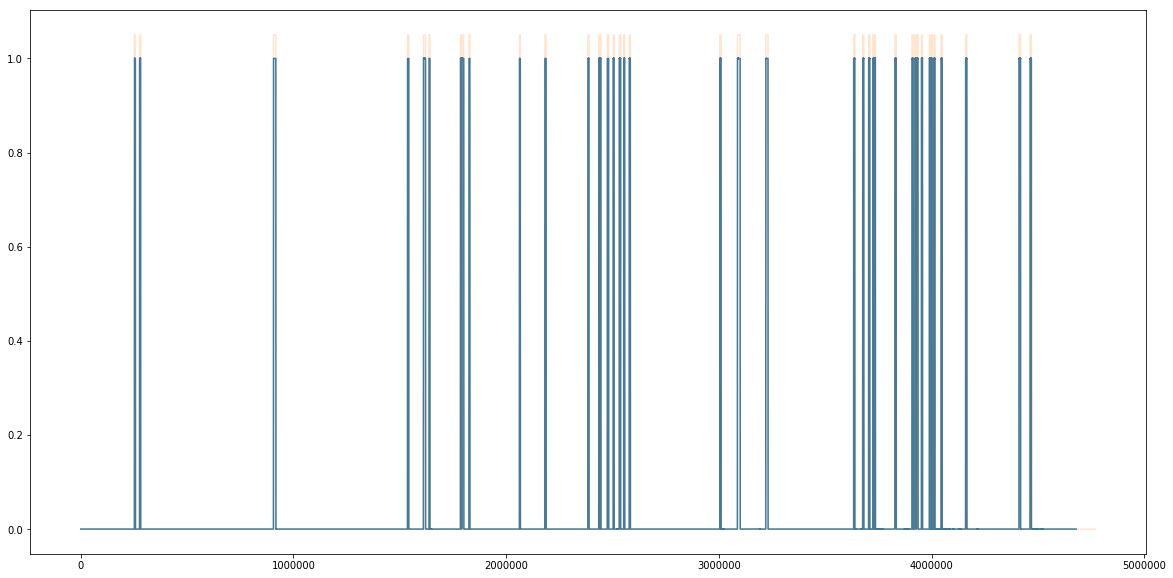

epoch 48 loss 0.0008976185521963448 time 14.511683225631714


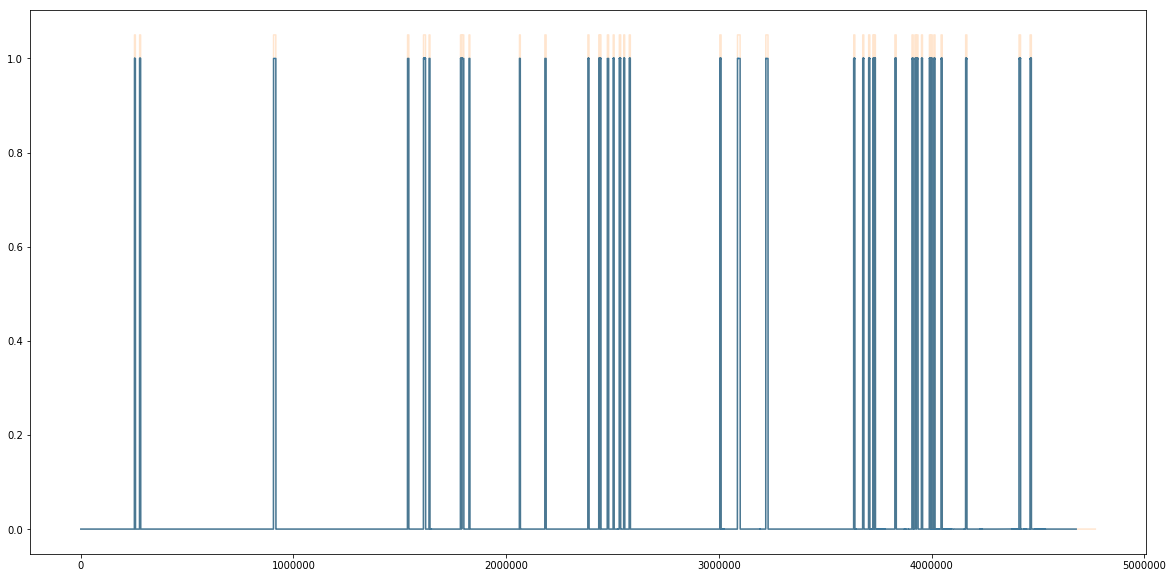

epoch 49 loss 0.0008267128827035585 time 14.541664361953735


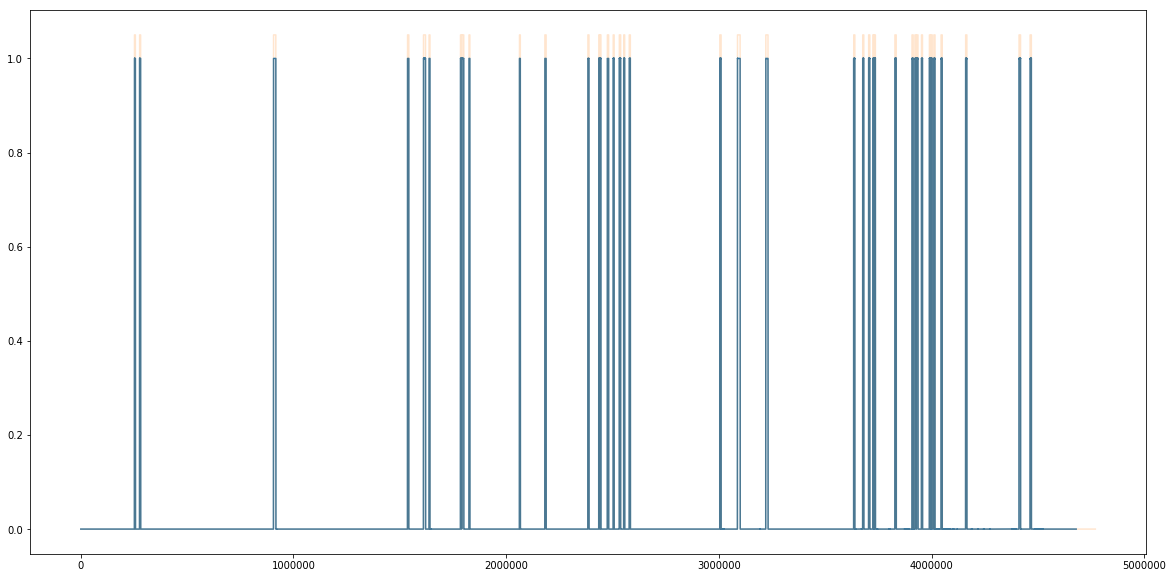

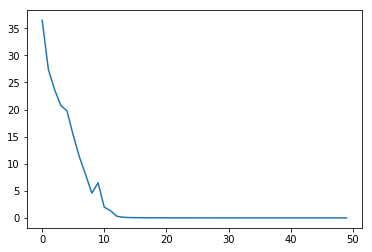

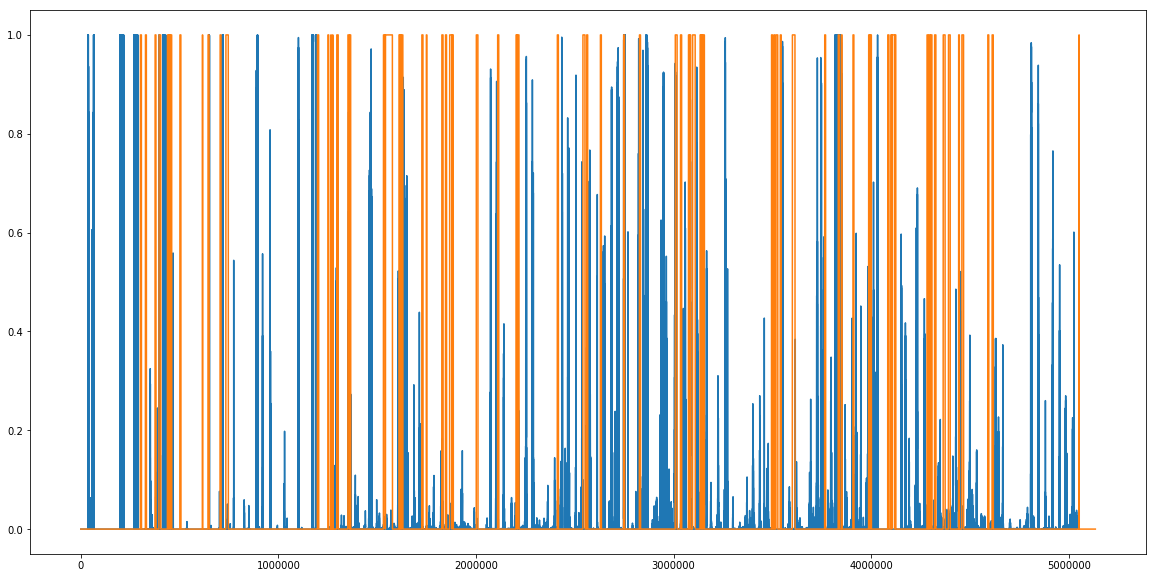

In [46]:
import time

train_dataset = SleepDataset('../data/training/RECORDS', '../data/training/', 0, 1)

train_loaders = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1, 
                                           shuffle=True)

def to_spectogram(matrix):
    spectograms = []
    for i in range(13):
        f, t, Sxx = signal.spectrogram(matrix[0,:,i].numpy(), 
                           window=signal.get_window('hann',256, False), 
                           fs=200, 
                           scaling='density', 
                           mode='magnitude',
                           noverlap=0
                          )
        spectograms.append(Sxx)
    return torch.FloatTensor(spectograms).unsqueeze(0).cuda()

# 36000 at window 256 -> (129, 140)
#                        (64, 70)
#                        (32, 35)
#                        (16, 17)

class Model(nn.Module):

    def __init__(self, slice_size):
        super(Model, self).__init__()
        self.cnn1 = nn.Conv2d(13, 16, 7, padding=3)
        init.xavier_uniform(self.cnn1.weight, gain=np.sqrt(2.0))
        init.constant(self.cnn1.bias, 0.1)
        self.cnn2 = nn.Conv2d(16, 16, 5, padding=2)
        init.xavier_uniform(self.cnn2.weight, gain=np.sqrt(2.0))
        init.constant(self.cnn2.bias, 0.1)
        self.cnn3 = nn.Conv2d(16, 16, 3, padding=1)
        init.xavier_uniform(self.cnn3.weight, gain=np.sqrt(2.0))
        init.constant(self.cnn3.bias, 0.1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
#         self.dropout2 = nn.Dropout2d()
        
#         self.dropout = nn.Dropout()
        
#         self.hidden = nn.Linear(16*17*64, 10000)
        
        self.output = nn.Linear(16*17*16, slice_size)
        
        self.sigmoid = nn.Sigmoid()
        
   
    def forward(self, x):
#         x = self.relu(self.pool(self.dropout2(self.cnn1(x))))
#         x = self.relu(self.pool(self.dropout2(self.cnn2(x))))
#         x = self.relu(self.pool(self.dropout2(self.cnn3(x))))
        x = self.relu(self.pool(self.cnn1(x)))
        x = self.relu(self.pool(self.cnn2(x)))
        x = self.relu(self.pool(self.cnn3(x)))
        x = x.view(1, -1)
#         print(x.size())
#         x = self.dropout(x)
#         x = self.relu(self.hidden(x))
        x = self.output(x)
        return self.sigmoid(x)

model_v1 = Model(36000)
model_v1.cuda()

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model_v1.parameters(), lr=1e-3)#, weight_decay=1e-3)  

losses = []
v_losses = []
l = None
for epoch in range(50):
    loss_t = 0.0
    start_time = time.time()
    for i, ((all_data, centers), labels) in enumerate(train_loaders):
#         for c in centers.view(-1).numpy():
#             c = int(c)
#             c += np.random.randint(-5000, 5000)
#             inp_subs = Variable(to_spectogram(all_data[:,c-18000:c+18000,]))

#             l = Variable(labels[0, c-18000:c+18000].type(torch.FloatTensor).cuda())
        for i in range((all_data.size()[1]//36000) - 2):
            inp_subs = Variable(to_spectogram(all_data[:,i*36000:(i+1)*36000,]))
            l = Variable(labels[0, i*36000:(i+1)*36000].type(torch.FloatTensor).cuda())
            output = model_v1(inp_subs)
            loss = criterion(output.view(-1), l)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_t += loss.data[0] / len(centers)
        
#             output = model(inp_v_subs)
#             loss = criterion(output.view(-1), v_l)
#             v_losses.append(loss.data[0])

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             loss_t += loss.data[0]

    losses.append(loss_t)
    print('epoch', epoch, 'loss', loss_t, 'time', time.time() - start_time)
    v_all = []
    for i in range((all_data.size()[1]//36000) - 2):
        inp_subs = Variable(to_spectogram(all_data[:,i*36000:(i+1)*36000,]))
        v_out = model_v1(inp_subs)
        v_all = np.append(v_all, v_out.cpu().data[0].numpy())
    fig = plt.figure(figsize=(20, 10))
    plt.plot(v_all)
    plt.plot(labels.numpy()[0]*1.05, alpha=0.2)
    plt.show()  
plt.plot(losses)
# plt.plot(v_losses)
plt.show()
# print('train')
# fig = plt.figure(figsize=(20, 10))
# plt.plot(model_v1(inp_subs).cpu().data[0].numpy())
# plt.plot(l.cpu().data.numpy())
# plt.show()

test_dataset = SleepDataset('../data/training/RECORDS', '../data/training/', 10, 11)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1, 
                                          shuffle=False)

i, ((data, cent), v_l) = next(enumerate(test_loader))

val_l = None
v_out = None
v_all = []
for i in range((data.size()[1]//36000) - 2):
    inp_subs = Variable(to_spectogram(data[:,i*36000:(i+1)*36000,]))
    v_out = model_v1(inp_subs)
    v_all = np.append(v_all, v_out.cpu().data[0].numpy())
fig = plt.figure(figsize=(20, 10))
plt.plot(v_all)
plt.plot(v_l.numpy()[0])
plt.show()  

In [51]:
inp_subs = Variable(to_spectogram(all_data[:,c-18000:c+18000,]))

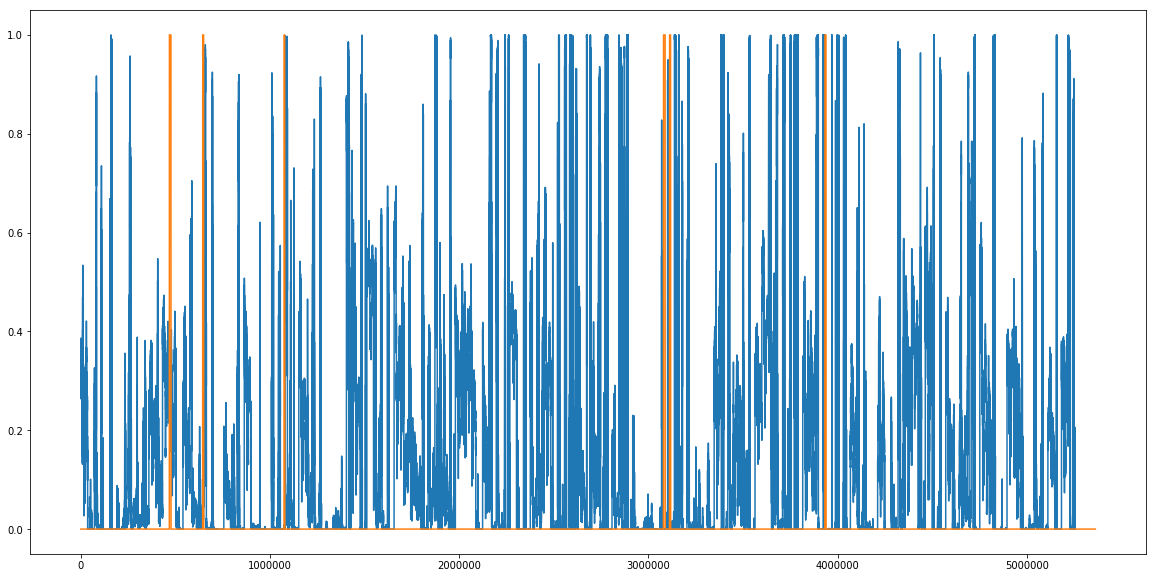

In [17]:
# val_l = None
# v_out = None
# v_all = []
# for i in range((data.size()[1]//36000) - 2):
#     inp_subs = Variable(to_spectogram(data[:,i*36000:(i+1)*36000,]))
#     v_out = model_v1(inp_subs)
#     v_all = np.append(v_all, v_out.cpu().data[0].numpy())
fig = plt.figure(figsize=(20, 10))
plt.plot(v_all)
plt.plot(v_l.numpy()[0])
plt.show() 

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

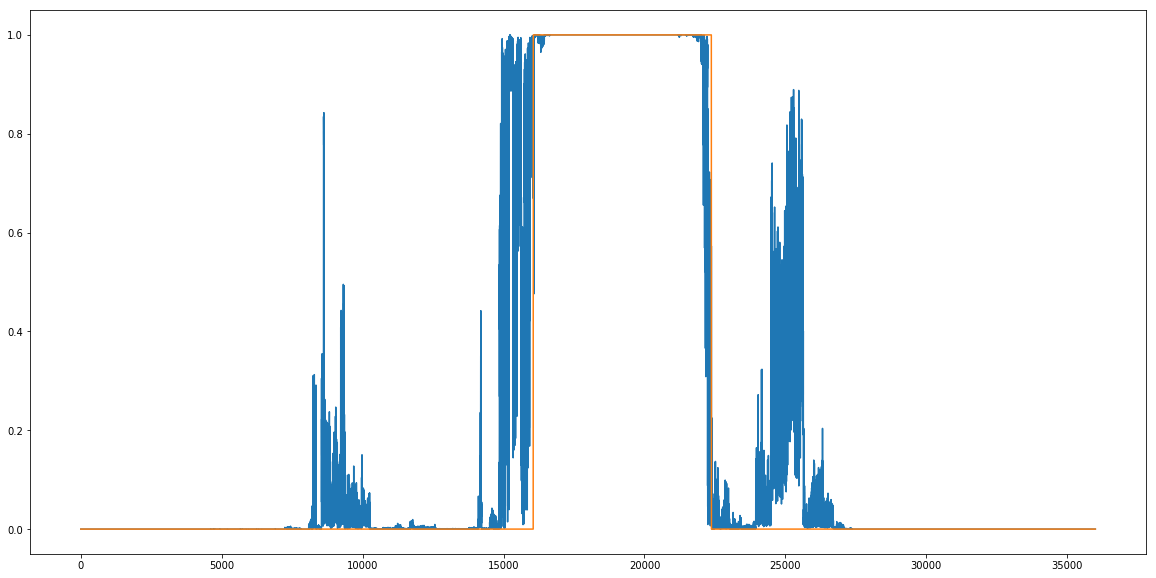

In [54]:
fig = plt.figure(figsize=(20, 10))
plt.plot(model_v1(inp_subs).cpu().data[0].numpy())
plt.plot(l.cpu().data.numpy())
plt.show()
# # print(v_l.numpy()[0])

In [40]:
np.random.randint(-5, 5)

4